In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [27]:
df = pd.read_csv("df_2.csv")

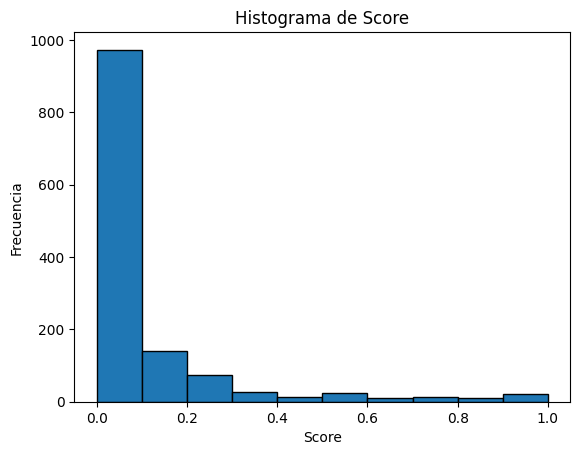

In [4]:
plt.hist(df["Score"], bins=10, edgecolor='black')

# Agregar títulos y etiquetas
plt.title('Histograma de Score')
plt.xlabel('Score')
plt.ylabel('Frecuencia')

# Mostrar gráfico
plt.show()


Submuestreo

In [13]:
percentil_10 = np.percentile(df['Score'], 10)
print(f'Percentil 10: {percentil_10}')


Percentil 10: 0.0023990401775453403


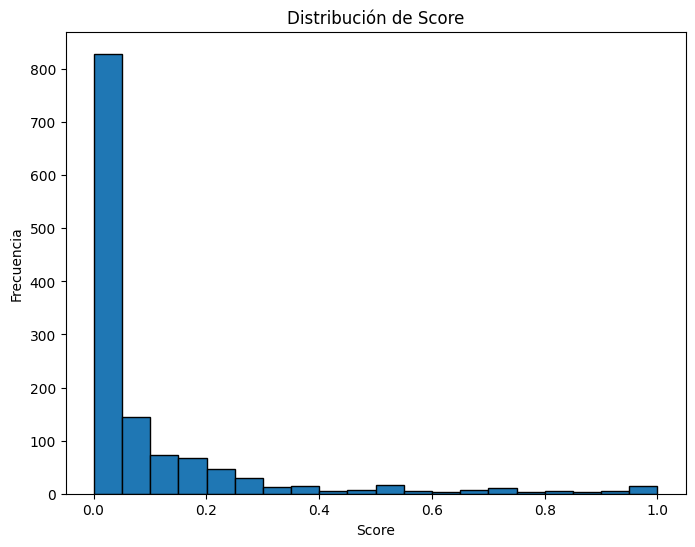

Tamaño original del DataFrame: 1304
Tamaño después del submuestreo: 1173


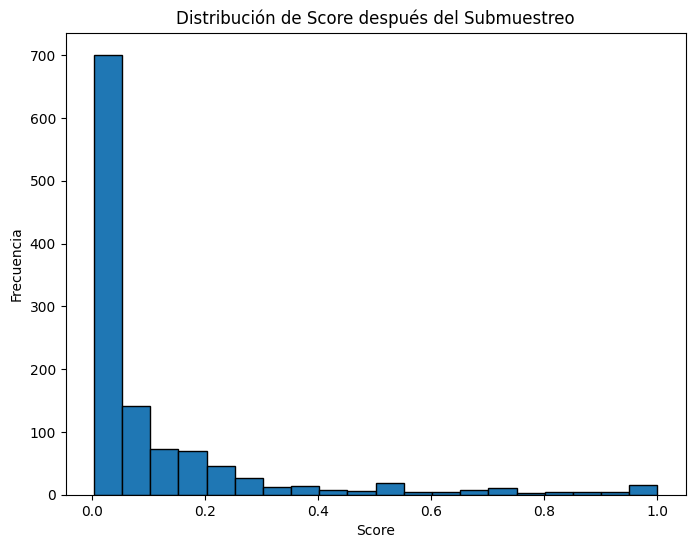

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Suponiendo que tienes un DataFrame llamado df con la variable 'Score'
# Vamos a mostrar un resumen de los valores de 'Score' para ver su distribución
score_distribution = df['Score'].describe()

# Histograma para visualizar la distribución de los valores de 'Score'
plt.figure(figsize=(8, 6))
plt.hist(df['Score'], bins=20, edgecolor='black')
plt.title('Distribución de Score')
plt.xlabel('Score')
plt.ylabel('Frecuencia')
plt.show()

# Vamos a establecer un umbral que define los valores cercanos a 0
# Esto depende de tu caso, pero por ejemplo podemos decir que los valores menores a 0.1 son cercanos a 0
threshold = 0.0023990401775453403

# Filtramos los datos con valores de Score cercanos a 0
low_score_data = df[df['Score'] <= threshold]

# Si quieres eliminar estos valores para hacer el submuestreo
# Eliminar los valores cercanos a 0 (puedes ajustar este umbral según sea necesario)
df_filtered = df[df['Score'] > threshold]

# Ver el tamaño original y el tamaño después del submuestreo
print(f'Tamaño original del DataFrame: {df.shape[0]}')
print(f'Tamaño después del submuestreo: {df_filtered.shape[0]}')

# Ver cómo queda la nueva distribución después de eliminar datos cercanos a 0
score_filtered_distribution = df_filtered['Score'].describe()

# Visualizar la distribución después del submuestreo
plt.figure(figsize=(8, 6))
plt.hist(df_filtered['Score'], bins=20, edgecolor='black')
plt.title('Distribución de Score después del Submuestreo')
plt.xlabel('Score')
plt.ylabel('Frecuencia')
plt.show()


In [21]:
df_2 = df_filtered

Fold 1
  RMSE: 0.1254 | R²: 0.6672 | MAE: 0.0696
Fold 2
  RMSE: 0.1467 | R²: 0.5005 | MAE: 0.0709
Fold 3
  RMSE: 0.1165 | R²: 0.7270 | MAE: 0.0645
Fold 4
  RMSE: 0.1559 | R²: 0.5115 | MAE: 0.0830
Fold 5
  RMSE: 0.1242 | R²: 0.6724 | MAE: 0.0740

RMSE promedio: 0.1337 (±0.0149)
R² promedio: 0.6157 (±0.0921)
MAE promedio: 0.0724 (±0.0061)


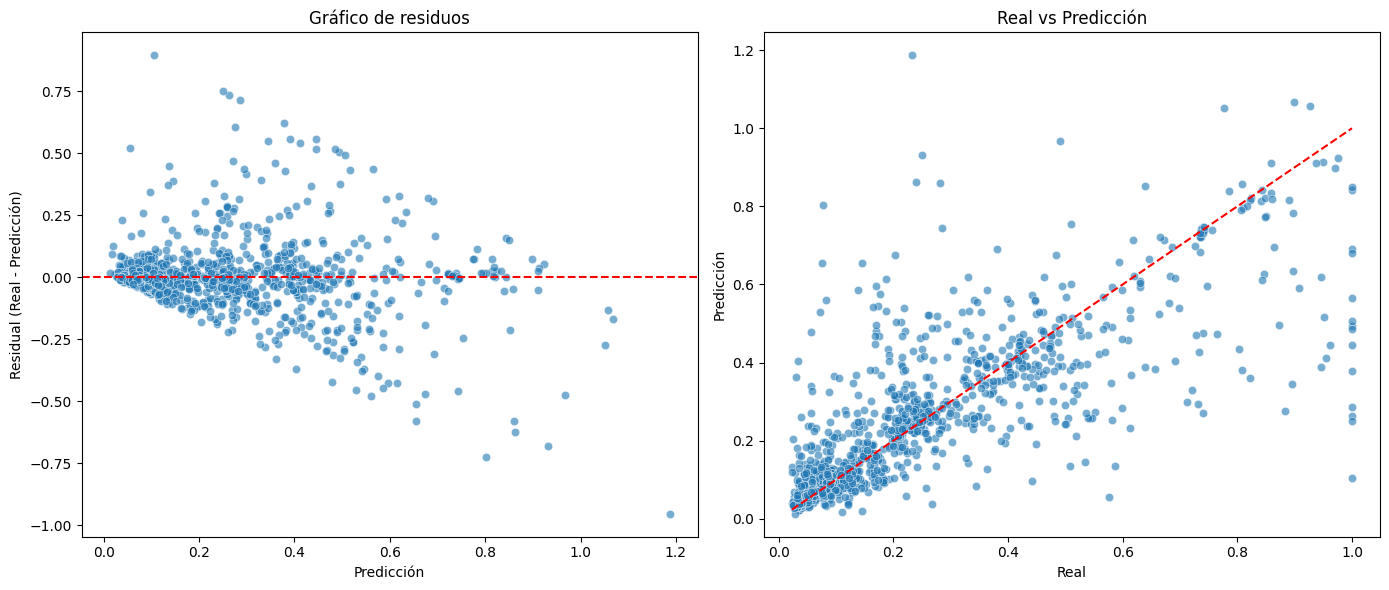

In [23]:
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold
from sklearn.preprocessing import OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
import seaborn as sns

# ---------- 1. Función de Preprocesamiento ----------
def preprocess_dataframe(df):
    y = df["Score"].values
    X = df.drop(columns=["Score"]).copy()

    # Codificación de variables categóricas
    cat_cols = ["Clase", "Eluyente1", "Eluyente2", "USP Code"]
    encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
    X[cat_cols] = encoder.fit_transform(X[cat_cols])

    return X, y, encoder

# ---------- 2. Preprocesamiento de datos ----------
X_processed, y, encoder = preprocess_dataframe(df)

# Transformación de la variable objetivo
y_transformed = y**0.25

# Pesos de ejemplo para dar más importancia a valores altos de Score
sample_weights = 1 + 4 * y

# ---------- 3. Validación cruzada ----------
kf = KFold(n_splits=5, shuffle=True, random_state=42)
rmse_scores = []
r2_scores = []
mae_scores = []

# Para visualización
all_y_test = []
all_y_pred = []

for fold, (train_index, test_index) in enumerate(kf.split(X_processed)):
    print(f"Fold {fold + 1}")

    X_train, X_test = X_processed.iloc[train_index], X_processed.iloc[test_index]
    y_train, y_test = y_transformed[train_index], y_transformed[test_index]
    weights_train = sample_weights[train_index]

    # Imputación
    imputer = SimpleImputer(strategy='mean')
    X_train_imputed = imputer.fit_transform(X_train)
    X_test_imputed = imputer.transform(X_test)

    # Entrenamiento del modelo XGBoost
    model = XGBRegressor(
        n_estimators=300,
        learning_rate=0.05,
        random_state=42,
        objective='reg:squarederror',
        verbosity=0
    )
    model.fit(X_train_imputed, y_train, sample_weight=weights_train)

    # Predicción
    y_pred = model.predict(X_test_imputed)

    # Destransformar
    y_pred_original = y_pred ** 2
    y_test_original = y_test ** 2

    # Guardar para visualización
    all_y_test.extend(y_test_original)
    all_y_pred.extend(y_pred_original)

    # Métricas
    rmse = np.sqrt(mean_squared_error(y_test_original, y_pred_original))
    r2 = r2_score(y_test_original, y_pred_original)
    mae = mean_absolute_error(y_test_original, y_pred_original)

    rmse_scores.append(rmse)
    r2_scores.append(r2)
    mae_scores.append(mae)

    print(f"  RMSE: {rmse:.4f} | R²: {r2:.4f} | MAE: {mae:.4f}")

# ---------- 4. Resultados Finales ----------
print(f"\nRMSE promedio: {np.mean(rmse_scores):.4f} (±{np.std(rmse_scores):.4f})")
print(f"R² promedio: {np.mean(r2_scores):.4f} (±{np.std(r2_scores):.4f})")
print(f"MAE promedio: {np.mean(mae_scores):.4f} (±{np.std(mae_scores):.4f})")

# ---------- 5. Visualización de Validación ----------
all_y_test = np.array(all_y_test)
all_y_pred = np.array(all_y_pred)
residuals = all_y_test - all_y_pred

plt.figure(figsize=(14, 6))

# Gráfico de residuos
plt.subplot(1, 2, 1)
sns.scatterplot(x=all_y_pred, y=residuals, alpha=0.6)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicción")
plt.ylabel("Residual (Real - Predicción)")
plt.title("Gráfico de residuos")

# Predicción vs Real
plt.subplot(1, 2, 2)
sns.scatterplot(x=all_y_test, y=all_y_pred, alpha=0.6)
plt.plot([min(all_y_test), max(all_y_test)], [min(all_y_test), max(all_y_test)], color='red', linestyle='--')
plt.xlabel("Real")
plt.ylabel("Predicción")
plt.title("Real vs Predicción")

plt.tight_layout()
plt.show()


Sobremuestreo

dist_matrix:   0%|          | 0/269 [00:00<?, ?it/s]

r_index: 100%|##########| 215/215 [00:00<00:00, 576.75it/s]
c:\Users\cmora\AppData\Local\Programs\Python\Python312\Lib\site-packages\smogn\over_sampling.py:439: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0                                                   22.0
1      Steroids and steroid derivatives (CHEMONTID:00...
2      Steroids and steroid derivatives (CHEMONTID:00...
3      Steroids and steroid derivatives (CHEMONTID:00...
4      Steroids and steroid derivatives (CHEMONTID:00...
                             ...                        
748                                                  7.0
749                                                 10.0
750                                                 22.0
751                                                  1.0
752                                                 10.0
Name: 0, Length: 753, dtype: object' has dtype incompatible with float64, please explicitly ca

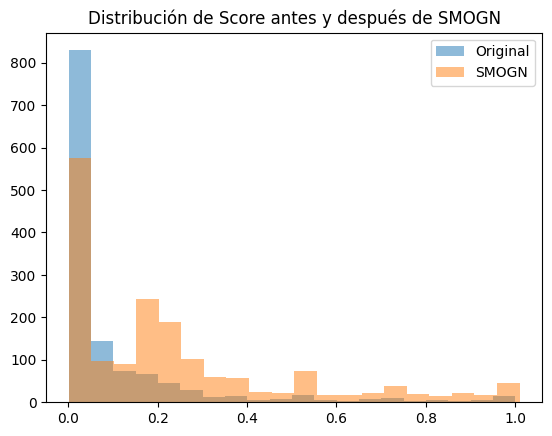

In [28]:
import pandas as pd
import smogn

# Suponiendo que 'Score' es tu variable objetivo
# SMOGN requiere que no haya NaNs
df_clean = df.dropna().reset_index(drop=True)


# Aplicar SMOGN
df_smogn = smogn.smoter(
    data = df_clean,
    y = "Score",              # variable objetivo
    k = 5,                    # número de vecinos
    samp_method = "extreme"   # también puedes probar "balance"
)

# Ver cómo cambió la distribución
import matplotlib.pyplot as plt
plt.hist(df['Score'], bins=20, alpha=0.5, label='Original')
plt.hist(df_smogn['Score'], bins=20, alpha=0.5, label='SMOGN')
plt.legend()
plt.title("Distribución de Score antes y después de SMOGN")
plt.show()


Fold 1
  RMSE: 0.1374 | R²: 0.7475 | MAE: 0.0776
Fold 2
  RMSE: 0.1372 | R²: 0.7439 | MAE: 0.0832
Fold 3
  RMSE: 0.1446 | R²: 0.6917 | MAE: 0.0938
Fold 4
  RMSE: 0.1420 | R²: 0.7341 | MAE: 0.0888
Fold 5
  RMSE: 0.1313 | R²: 0.7522 | MAE: 0.0820

RMSE promedio: 0.1385 (±0.0046)
R² promedio: 0.7339 (±0.0219)
MAE promedio: 0.0851 (±0.0056)


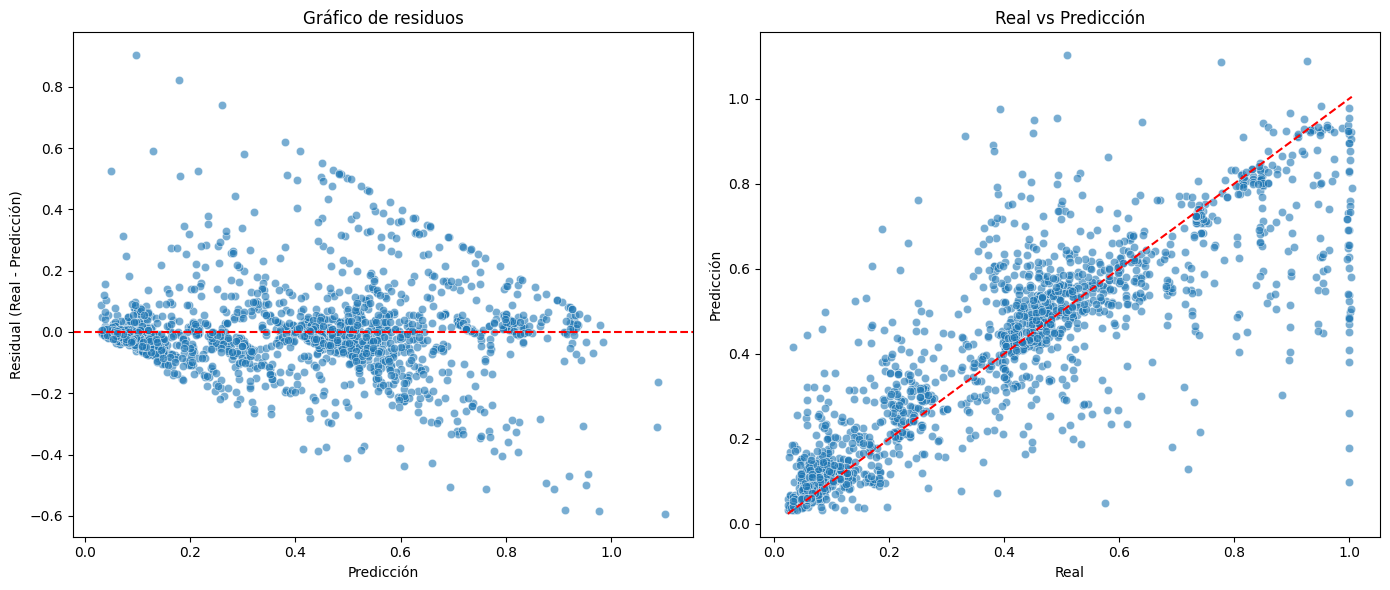

In [29]:
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold
from sklearn.preprocessing import OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
import seaborn as sns

# ---------- 1. Función de Preprocesamiento ----------
def preprocess_dataframe(df):
    y = df["Score"].values
    X = df.drop(columns=["Score"]).copy()

    # Codificación de variables categóricas
    cat_cols = ["Clase", "Eluyente1", "Eluyente2", "USP Code"]
    encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
    X[cat_cols] = encoder.fit_transform(X[cat_cols])

    return X, y, encoder

# ---------- 2. Preprocesamiento de datos ----------
X_processed, y, encoder = preprocess_dataframe(df_smogn)

# Transformación de la variable objetivo
y_transformed = y**0.25

# Pesos de ejemplo para dar más importancia a valores altos de Score
sample_weights = 1 + 4 * y

# ---------- 3. Validación cruzada ----------
kf = KFold(n_splits=5, shuffle=True, random_state=42)
rmse_scores = []
r2_scores = []
mae_scores = []

# Para visualización
all_y_test = []
all_y_pred = []

for fold, (train_index, test_index) in enumerate(kf.split(X_processed)):
    print(f"Fold {fold + 1}")

    X_train, X_test = X_processed.iloc[train_index], X_processed.iloc[test_index]
    y_train, y_test = y_transformed[train_index], y_transformed[test_index]
    weights_train = sample_weights[train_index]

    # Imputación
    imputer = SimpleImputer(strategy='mean')
    X_train_imputed = imputer.fit_transform(X_train)
    X_test_imputed = imputer.transform(X_test)

    # Entrenamiento del modelo XGBoost
    model = XGBRegressor(
        n_estimators=300,
        learning_rate=0.05,
        random_state=42,
        objective='reg:squarederror',
        verbosity=0
    )
    model.fit(X_train_imputed, y_train, sample_weight=weights_train)

    # Predicción
    y_pred = model.predict(X_test_imputed)

    # Destransformar
    y_pred_original = y_pred ** 2
    y_test_original = y_test ** 2

    # Guardar para visualización
    all_y_test.extend(y_test_original)
    all_y_pred.extend(y_pred_original)

    # Métricas
    rmse = np.sqrt(mean_squared_error(y_test_original, y_pred_original))
    r2 = r2_score(y_test_original, y_pred_original)
    mae = mean_absolute_error(y_test_original, y_pred_original)

    rmse_scores.append(rmse)
    r2_scores.append(r2)
    mae_scores.append(mae)

    print(f"  RMSE: {rmse:.4f} | R²: {r2:.4f} | MAE: {mae:.4f}")

# ---------- 4. Resultados Finales ----------
print(f"\nRMSE promedio: {np.mean(rmse_scores):.4f} (±{np.std(rmse_scores):.4f})")
print(f"R² promedio: {np.mean(r2_scores):.4f} (±{np.std(r2_scores):.4f})")
print(f"MAE promedio: {np.mean(mae_scores):.4f} (±{np.std(mae_scores):.4f})")

# ---------- 5. Visualización de Validación ----------
all_y_test = np.array(all_y_test)
all_y_pred = np.array(all_y_pred)
residuals = all_y_test - all_y_pred

plt.figure(figsize=(14, 6))

# Gráfico de residuos
plt.subplot(1, 2, 1)
sns.scatterplot(x=all_y_pred, y=residuals, alpha=0.6)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicción")
plt.ylabel("Residual (Real - Predicción)")
plt.title("Gráfico de residuos")

# Predicción vs Real
plt.subplot(1, 2, 2)
sns.scatterplot(x=all_y_test, y=all_y_pred, alpha=0.6)
plt.plot([min(all_y_test), max(all_y_test)], [min(all_y_test), max(all_y_test)], color='red', linestyle='--')
plt.xlabel("Real")
plt.ylabel("Predicción")
plt.title("Real vs Predicción")

plt.tight_layout()
plt.show()


In [44]:
import pandas as pd
import numpy as np

# y_true y y_pred son los valores reales y predichos por tu modelo
# Supongamos que ya los tienes tras validar con cross-validation
errores = pd.DataFrame({'true': all_y_test, 'pred': all_y_pred})
errores['abs_error'] = np.abs(errores['true'] - errores['pred'])

# Comparar el error en extremos
umbral_alto = 0.8
errores_extremos = errores[errores['true'] > umbral_alto]
print("MAE en extremos (>0.8):", errores_extremos['abs_error'].mean())
print("MAE general:", errores['abs_error'].mean())


MAE en extremos (>0.8): 0.18705097592908465
MAE general: 0.08311644373800128


In [42]:
import smogn
import numpy as np

# Asegúrate de que los puntos de control sean correctos
relevancia = np.array([
    [0.0, 0.0],  # Baja relevancia
    [0.7, 0.0],  # Baja relevancia
    [0.8, 1.0],  # Alta relevancia
    [1.0, 1.0]   # Máxima relevancia
])

print(f"Shape of relevance control points: {relevancia.shape}")

# Suponiendo que df_clean es tu DataFrame limpio
df_clean = df.dropna().reset_index(drop=True)

# Ahora utilizamos rel_method = 'auto' para ver si SMOGN puede determinar la relevancia automáticamente
df_smogn = smogn.smoter(
    data=df_clean,
    y='Score',
    k=5,
    samp_method='extreme',
    rel_method='auto',  # Cambiado de 'manual' a 'auto'
    rel_ctrl_pts_rg=relevancia  # Usamos los puntos de control
)

# Visualiza el resultado
print(df_smogn.head())


Shape of relevance control points: (4, 2)


r_index: 100%|##########| 215/215 [00:00<00:00, 557.11it/s]

                                               Clase       Eluyente1  \
0  Steroids and steroid derivatives (CHEMONTID:00...  eluent.1.h2o 0   
1  Steroids and steroid derivatives (CHEMONTID:00...  eluent.1.h2o 0   
2  Steroids and steroid derivatives (CHEMONTID:00...  eluent.1.h2o 0   
3  Steroids and steroid derivatives (CHEMONTID:00...  eluent.1.h2o 0   
4  Steroids and steroid derivatives (CHEMONTID:00...  eluent.1.h2o 0   

         Eluyente2       pH1       pH2            USP Code    Longitud  \
0  eluent.2.meoh 0  3.591084  3.594815  column.usp.code_L1   99.562319   
1  eluent.2.meoh 0  4.300373  4.300373  column.usp.code_L1  100.000000   
2  eluent.2.meoh 0  2.997185  2.991907  column.usp.code_L1   99.796248   
3  eluent.2.meoh 0  3.029444  3.000058  column.usp.code_L1  100.722458   
4  eluent.2.meoh 0  2.603817  0.000000  column.usp.code_L1   49.993599   

   Tamaño de Partícula  Temperatura     Flujo  ...          x3         x4  \
0             2.076366    30.174530  0.199818


c:\Users\cmora\AppData\Local\Programs\Python\Python312\Lib\site-packages\smogn\over_sampling.py:439: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0      Steroids and steroid derivatives (CHEMONTID:00...
1      Steroids and steroid derivatives (CHEMONTID:00...
2      Steroids and steroid derivatives (CHEMONTID:00...
3      Steroids and steroid derivatives (CHEMONTID:00...
4      Steroids and steroid derivatives (CHEMONTID:00...
                             ...                        
748                                                  8.0
749                                                 14.0
750                                                  7.0
751                                                 13.0
752    Steroids and steroid derivatives (CHEMONTID:00...
Name: 0, Length: 753, dtype: object' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  data_new.iloc[:, j] = dat

In [6]:
df_smogn.to_csv('df_smogn.csv', index=False) 

NameError: name 'df_smogn' is not defined

In [11]:
df_smogn = pd.read_csv("df_smogn.csv")

In [12]:
df_smogn.columns

Index(['Clase', 'Eluyente1', 'Eluyente2', 'pH1', 'pH2', 'USP Code', 'Longitud',
       'Tamaño de Partícula', 'Temperatura', 'Flujo', 'T0', 'Score', 'x1',
       'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8', 'x9', 'x10', 'Intercepto',
       'duration'],
      dtype='object')

In [10]:
print(set(df_smogn["Clase"]))

{'Keto acids and derivatives (CHEMONTID:0000389)', 'Prenol lipids (CHEMONTID:0000259)', 'Pyridines and derivatives (CHEMONTID:0000089)', 'Diazines (CHEMONTID:0001346)', 'Indoles and derivatives (CHEMONTID:0000211)', 'Phenylpropanoic acids (CHEMONTID:0002551)', 'Organonitrogen compounds (CHEMONTID:0000278)', 'Pyrimidine nucleosides (CHEMONTID:0000480)', 'Lactones (CHEMONTID:0000050)', 'Organic thiophosphoric acids and derivatives (CHEMONTID:0001303)', 'Coumarins and derivatives (CHEMONTID:0000145)', 'Purine nucleotides (CHEMONTID:0001506)', 'Hydroxy acids and derivatives (CHEMONTID:0000472)', 'Purine nucleosides (CHEMONTID:0000479)', 'Phenols (CHEMONTID:0000134)', 'Cinnamic acids and derivatives (CHEMONTID:0000476)', 'Pyrimidine nucleotides (CHEMONTID:0001509)', 'Azoles (CHEMONTID:0000436)', 'Benzene and substituted derivatives (CHEMONTID:0002279)', 'Carboxylic acids and derivatives (CHEMONTID:0000265)', 'Organooxygen compounds (CHEMONTID:0000323)', 'Coumarans (CHEMONTID:0004189)', 'Fat

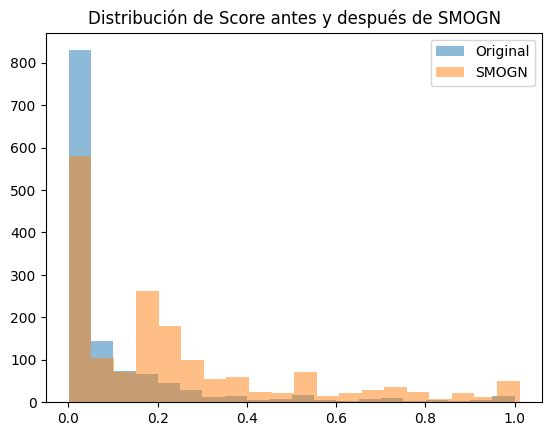

In [46]:

# Ver cómo cambió la distribución
import matplotlib.pyplot as plt
plt.hist(df['Score'], bins=20, alpha=0.5, label='Original')
plt.hist(df_smogn['Score'], bins=20, alpha=0.5, label='SMOGN')
plt.legend()
plt.title("Distribución de Score antes y después de SMOGN")
plt.show()


In [13]:
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold
from sklearn.preprocessing import OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
import seaborn as sns

# ---------- 1. Función de Preprocesamiento ----------
def preprocess_dataframe(df):
    y = df["Score"].values
    X = df.drop(columns=["Score"]).copy()

    # Codificación de variables categóricas
    cat_cols = ["Clase", "Eluyente1", "Eluyente2", "USP Code"]
    encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
    X[cat_cols] = encoder.fit_transform(X[cat_cols])

    return X, y, encoder

# ---------- 2. Preprocesamiento de datos ----------
X_processed, y, encoder = preprocess_dataframe(df_smogn)

# Transformación de la variable objetivo
y_transformed = y**0.25

# Pesos de ejemplo para dar más importancia a valores altos de Score
sample_weights = 1 + 4 * y

# ---------- 3. Validación cruzada ----------
kf = KFold(n_splits=5, shuffle=True, random_state=42)
rmse_scores = []
r2_scores = []
mae_scores = []

# Para visualización
all_y_test = []
all_y_pred = []

for fold, (train_index, test_index) in enumerate(kf.split(X_processed)):
    print(f"Fold {fold + 1}")

    X_train, X_test = X_processed.iloc[train_index], X_processed.iloc[test_index]
    y_train, y_test = y_transformed[train_index], y_transformed[test_index]
    weights_train = sample_weights[train_index]

    # Imputación
    imputer = SimpleImputer(strategy='mean')
    X_train_imputed = imputer.fit_transform(X_train)
    X_test_imputed = imputer.transform(X_test)

    # Entrenamiento del modelo XGBoost
    model = XGBRegressor(
        n_estimators=300,
        learning_rate=0.05,
        random_state=42,
        objective='reg:squarederror',
        verbosity=0
    )
    model.fit(X_train_imputed, y_train, sample_weight=weights_train)

    # Predicción
    y_pred = model.predict(X_test_imputed)

    # Destransformar
    y_pred_original = y_pred ** 2
    y_test_original = y_test ** 2

    # Guardar para visualización
    all_y_test.extend(y_test_original)
    all_y_pred.extend(y_pred_original)

    # Métricas
    rmse = np.sqrt(mean_squared_error(y_test_original, y_pred_original))
    r2 = r2_score(y_test_original, y_pred_original)
    mae = mean_absolute_error(y_test_original, y_pred_original)

    rmse_scores.append(rmse)
    r2_scores.append(r2)
    mae_scores.append(mae)

    print(f"  RMSE: {rmse:.4f} | R²: {r2:.4f} | MAE: {mae:.4f}")

# ---------- 4. Resultados Finales ----------
print(f"\nRMSE promedio: {np.mean(rmse_scores):.4f} (±{np.std(rmse_scores):.4f})")
print(f"R² promedio: {np.mean(r2_scores):.4f} (±{np.std(r2_scores):.4f})")
print(f"MAE promedio: {np.mean(mae_scores):.4f} (±{np.std(mae_scores):.4f})")

# ---------- 5. Visualización de Validación ----------
all_y_test = np.array(all_y_test)
all_y_pred = np.array(all_y_pred)
residuals = all_y_test - all_y_pred

plt.figure(figsize=(14, 6))

# Gráfico de residuos
plt.subplot(1, 2, 1)
sns.scatterplot(x=all_y_pred, y=residuals, alpha=0.6)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicción")
plt.ylabel("Residual (Real - Predicción)")
plt.title("Gráfico de residuos")

# Predicción vs Real
plt.subplot(1, 2, 2)
sns.scatterplot(x=all_y_test, y=all_y_pred, alpha=0.6)
plt.plot([min(all_y_test), max(all_y_test)], [min(all_y_test), max(all_y_test)], color='red', linestyle='--')
plt.xlabel("Real")
plt.ylabel("Predicción")
plt.title("Real vs Predicción")

plt.tight_layout()
plt.show()

import joblib

joblib.dump({
    'model': model,
    'imputer': imputer,
    'encoder': encoder
}, "modelo_xgboost.pkl")

print("Modelo guardado como modelo_xgboost.pkl")



FileNotFoundError: [Errno 2] No such file or directory: '/content/archivo_base.csv'

In [58]:
import pandas as pd
import numpy as np

# y_true y y_pred son los valores reales y predichos por tu modelo
# Supongamos que ya los tienes tras validar con cross-validation
errores = pd.DataFrame({'true': all_y_test, 'pred': all_y_pred})
errores['abs_error'] = np.abs(errores['true'] - errores['pred'])

# Comparar el error en extremos
umbral_alto = 0.8
errores_extremos = errores[errores['true'] > umbral_alto]
print("MAE en extremos (>0.8):", errores_extremos['abs_error'].mean())
print("MAE general:", errores['abs_error'].mean())


MAE en extremos (>0.8): 0.18705097592908465
MAE general: 0.08311644373800128


OTROS MODELOS

Fold 1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001075 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3014
[LightGBM] [Info] Number of data points in the train set: 1396, number of used features: 22
[LightGBM] [Info] Start training from score 0.698687


c:\Users\cmora\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
c:\Users\cmora\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


  RMSE: 0.1346 | R²: 0.7637 | MAE: 0.0835
Fold 2
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000553 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3026
[LightGBM] [Info] Number of data points in the train set: 1397, number of used features: 22
[LightGBM] [Info] Start training from score 0.699779
  RMSE: 0.1484 | R²: 0.6921 | MAE: 0.0900
Fold 3
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000509 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2885
[LightGBM] [Info] Number of data points in the train set: 1397, number of used features: 22
[LightGBM] [Info] Start training from score 0.697854


c:\Users\cmora\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
c:\Users\cmora\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


  RMSE: 0.1428 | R²: 0.7306 | MAE: 0.0869
Fold 4
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000483 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3059
[LightGBM] [Info] Number of data points in the train set: 1397, number of used features: 22
[LightGBM] [Info] Start training from score 0.703088
  RMSE: 0.1426 | R²: 0.7164 | MAE: 0.0851
Fold 5
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000516 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3172
[LightGBM] [Info] Number of data points in the train set: 1397, number of used features: 22
[LightGBM] [Info] Start training from score 0.705467


c:\Users\cmora\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


  RMSE: 0.1369 | R²: 0.7440 | MAE: 0.0824

RMSE promedio: 0.1410 (±0.0049)
R² promedio: 0.7293 (±0.0243)
MAE promedio: 0.0856 (±0.0027)


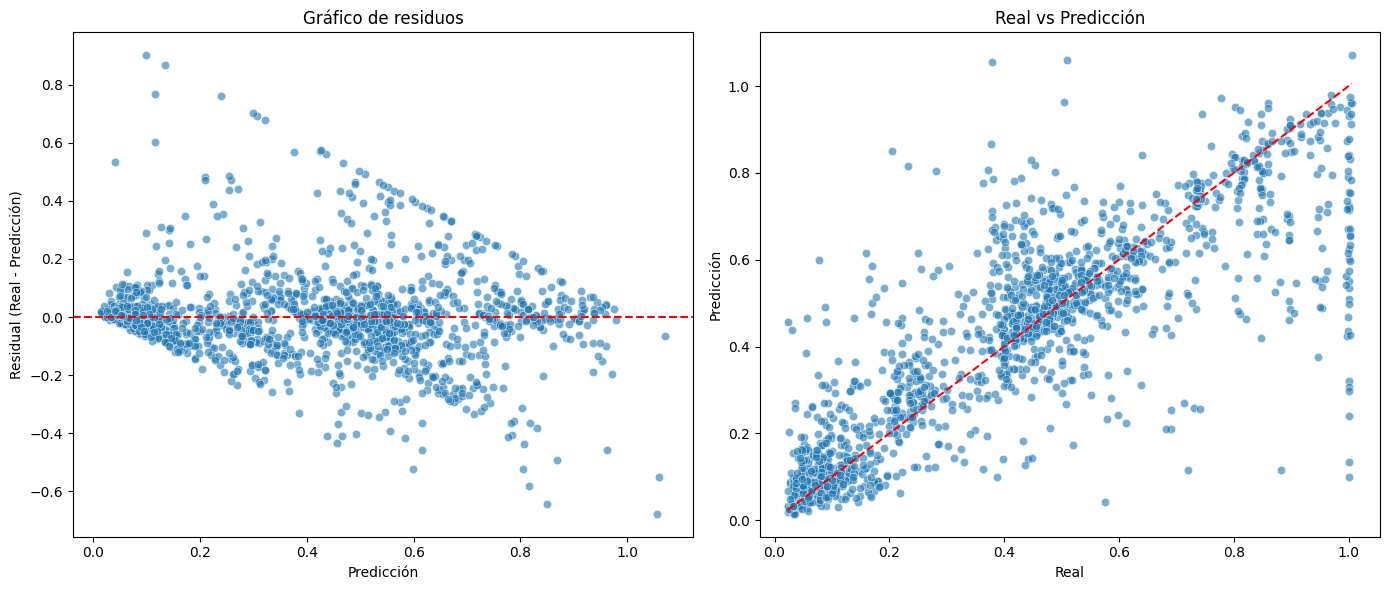

In [53]:
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold
from sklearn.preprocessing import OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from lightgbm import LGBMRegressor
import matplotlib.pyplot as plt
import seaborn as sns

# ---------- 1. Función de Preprocesamiento ----------
def preprocess_dataframe(df):
    y = df["Score"].values
    X = df.drop(columns=["Score"]).copy()

    # Codificación de variables categóricas
    cat_cols = ["Clase", "Eluyente1", "Eluyente2", "USP Code"]
    encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
    X[cat_cols] = encoder.fit_transform(X[cat_cols])

    return X, y, encoder

# ---------- 2. Preprocesamiento de datos ----------
X_processed, y, encoder = preprocess_dataframe(df_smogn)

# Transformación de la variable objetivo
y_transformed = y**0.25

# Pesos de ejemplo para dar más importancia a valores altos de Score
sample_weights = 1 + 4 * y

# ---------- 3. Validación cruzada ----------
kf = KFold(n_splits=5, shuffle=True, random_state=42)
rmse_scores = []
r2_scores = []
mae_scores = []

# Para visualización
all_y_test = []
all_y_pred = []

for fold, (train_index, test_index) in enumerate(kf.split(X_processed)):
    print(f"Fold {fold + 1}")

    X_train, X_test = X_processed.iloc[train_index], X_processed.iloc[test_index]
    y_train, y_test = y_transformed[train_index], y_transformed[test_index]
    weights_train = sample_weights[train_index]

    # Imputación
    imputer = SimpleImputer(strategy='mean')
    X_train_imputed = imputer.fit_transform(X_train)
    X_test_imputed = imputer.transform(X_test)

    # Entrenamiento del modelo LightGBM
    model = LGBMRegressor(n_estimators=300, learning_rate=0.05, random_state=42)
    model.fit(X_train_imputed, y_train, sample_weight=weights_train)  

    # Predicción
    y_pred = model.predict(X_test_imputed)

    # Destransformar
    y_pred_original = y_pred ** 2 
    y_test_original = y_test ** 2

    # Guardar para visualización
    all_y_test.extend(y_test_original)
    all_y_pred.extend(y_pred_original)

    # Métricas
    rmse = np.sqrt(mean_squared_error(y_test_original, y_pred_original))
    r2 = r2_score(y_test_original, y_pred_original)
    mae = mean_absolute_error(y_test_original, y_pred_original)

    rmse_scores.append(rmse)
    r2_scores.append(r2)
    mae_scores.append(mae)

    print(f"  RMSE: {rmse:.4f} | R²: {r2:.4f} | MAE: {mae:.4f}")

# ---------- 4. Resultados Finales ----------
print(f"\nRMSE promedio: {np.mean(rmse_scores):.4f} (±{np.std(rmse_scores):.4f})")
print(f"R² promedio: {np.mean(r2_scores):.4f} (±{np.std(r2_scores):.4f})")
print(f"MAE promedio: {np.mean(mae_scores):.4f} (±{np.std(mae_scores):.4f})")

# ---------- 5. Visualización de Validación ----------
all_y_test = np.array(all_y_test)
all_y_pred = np.array(all_y_pred)
residuals = all_y_test - all_y_pred

plt.figure(figsize=(14, 6))

# Gráfico de residuos
plt.subplot(1, 2, 1)
sns.scatterplot(x=all_y_pred, y=residuals, alpha=0.6)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicción")
plt.ylabel("Residual (Real - Predicción)")
plt.title("Gráfico de residuos")

# Predicción vs Real
plt.subplot(1, 2, 2)
sns.scatterplot(x=all_y_test, y=all_y_pred, alpha=0.6)
plt.plot([min(all_y_test), max(all_y_test)], [min(all_y_test), max(all_y_test)], color='red', linestyle='--')
plt.xlabel("Real")
plt.ylabel("Predicción")
plt.title("Real vs Predicción")

plt.tight_layout()
plt.show()

In [54]:
import pandas as pd
import numpy as np

# y_true y y_pred son los valores reales y predichos por tu modelo
# Supongamos que ya los tienes tras validar con cross-validation
errores = pd.DataFrame({'true': all_y_test, 'pred': all_y_pred})
errores['abs_error'] = np.abs(errores['true'] - errores['pred'])

# Comparar el error en extremos
umbral_alto = 0.8
errores_extremos = errores[errores['true'] > umbral_alto]
print("MAE en extremos (>0.8):", errores_extremos['abs_error'].mean())
print("MAE general:", errores['abs_error'].mean())


MAE en extremos (>0.8): 0.18442595491338237
MAE general: 0.08559856351668896


Fold 1
  RMSE: 0.1328 | R²: 0.7699 | MAE: 0.0750
Fold 2
  RMSE: 0.1452 | R²: 0.7052 | MAE: 0.0840
Fold 3
  RMSE: 0.1444 | R²: 0.7244 | MAE: 0.0840
Fold 4
  RMSE: 0.1360 | R²: 0.7417 | MAE: 0.0786
Fold 5
  RMSE: 0.1298 | R²: 0.7697 | MAE: 0.0749

RMSE promedio: 0.1377 (±0.0062)
R² promedio: 0.7422 (±0.0253)
MAE promedio: 0.0793 (±0.0041)


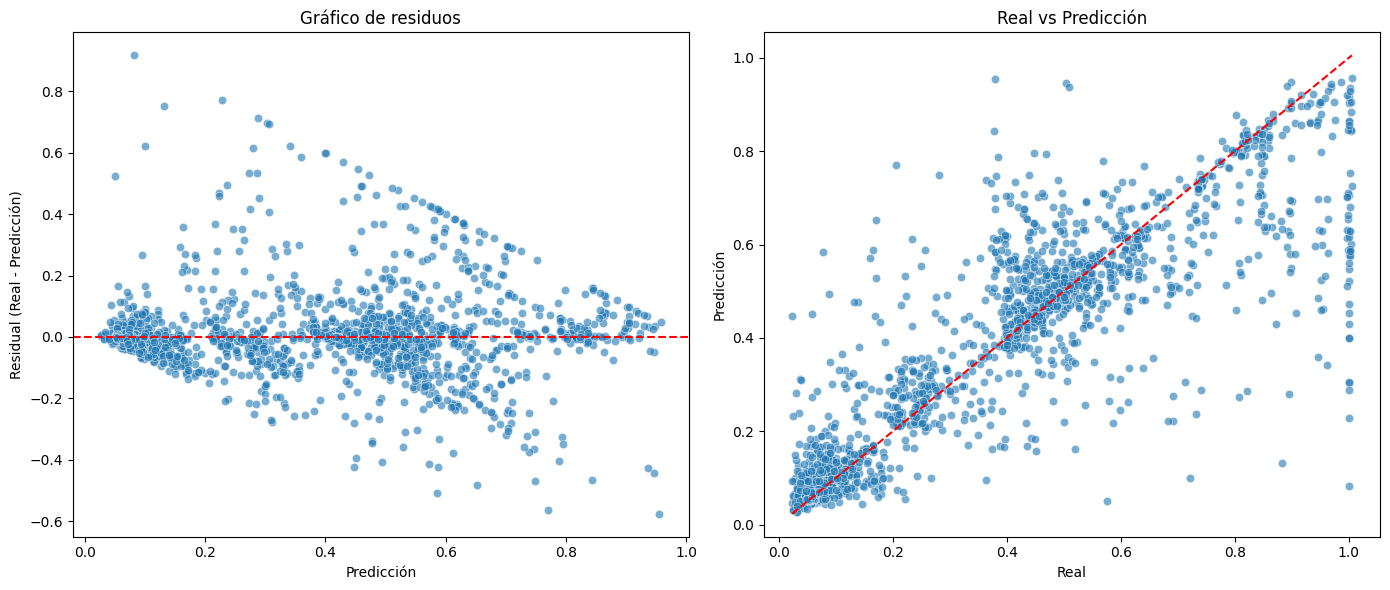

In [55]:
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold
from sklearn.preprocessing import OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns

# ---------- 1. Función de Preprocesamiento ----------
def preprocess_dataframe(df):
    y = df["Score"].values
    X = df.drop(columns=["Score"]).copy()

    # Codificación de variables categóricas
    cat_cols = ["Clase", "Eluyente1", "Eluyente2", "USP Code"]
    encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
    X[cat_cols] = encoder.fit_transform(X[cat_cols])

    return X, y, encoder

# ---------- 2. Preprocesamiento de datos ----------
X_processed, y, encoder = preprocess_dataframe(df_smogn)

# Transformación de la variable objetivo
y_transformed = y**0.25

# Pesos de ejemplo para dar más importancia a valores altos de Score
sample_weights = 1 + 4 * y

# ---------- 3. Validación cruzada ----------
kf = KFold(n_splits=5, shuffle=True, random_state=42)
rmse_scores = []
r2_scores = []
mae_scores = []

# Para visualización
all_y_test = []
all_y_pred = []

for fold, (train_index, test_index) in enumerate(kf.split(X_processed)):
    print(f"Fold {fold + 1}")

    X_train, X_test = X_processed.iloc[train_index], X_processed.iloc[test_index]
    y_train, y_test = y_transformed[train_index], y_transformed[test_index]
    weights_train = sample_weights[train_index]

    # Imputación
    imputer = SimpleImputer(strategy='mean')
    X_train_imputed = imputer.fit_transform(X_train)
    X_test_imputed = imputer.transform(X_test)

    # Entrenamiento del modelo Random Forest
    model = RandomForestRegressor(
        n_estimators=300,
        max_depth=None,
        random_state=42,
        n_jobs=-1
    )
    model.fit(X_train_imputed, y_train, sample_weight=weights_train)

    # Predicción
    y_pred = model.predict(X_test_imputed)

    # Destransformar
    y_pred_original = y_pred ** 2
    y_test_original = y_test ** 2

    # Guardar para visualización
    all_y_test.extend(y_test_original)
    all_y_pred.extend(y_pred_original)

    # Métricas
    rmse = np.sqrt(mean_squared_error(y_test_original, y_pred_original))
    r2 = r2_score(y_test_original, y_pred_original)
    mae = mean_absolute_error(y_test_original, y_pred_original)

    rmse_scores.append(rmse)
    r2_scores.append(r2)
    mae_scores.append(mae)

    print(f"  RMSE: {rmse:.4f} | R²: {r2:.4f} | MAE: {mae:.4f}")

# ---------- 4. Resultados Finales ----------
print(f"\nRMSE promedio: {np.mean(rmse_scores):.4f} (±{np.std(rmse_scores):.4f})")
print(f"R² promedio: {np.mean(r2_scores):.4f} (±{np.std(r2_scores):.4f})")
print(f"MAE promedio: {np.mean(mae_scores):.4f} (±{np.std(mae_scores):.4f})")

# ---------- 5. Visualización de Validación ----------
all_y_test = np.array(all_y_test)
all_y_pred = np.array(all_y_pred)
residuals = all_y_test - all_y_pred

plt.figure(figsize=(14, 6))

# Gráfico de residuos
plt.subplot(1, 2, 1)
sns.scatterplot(x=all_y_pred, y=residuals, alpha=0.6)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicción")
plt.ylabel("Residual (Real - Predicción)")
plt.title("Gráfico de residuos")

# Predicción vs Real
plt.subplot(1, 2, 2)
sns.scatterplot(x=all_y_test, y=all_y_pred, alpha=0.6)
plt.plot([min(all_y_test), max(all_y_test)], [min(all_y_test), max(all_y_test)], color='red', linestyle='--')
plt.xlabel("Real")
plt.ylabel("Predicción")
plt.title("Real vs Predicción")

plt.tight_layout()
plt.show()


In [56]:
import pandas as pd
import numpy as np

# y_true y y_pred son los valores reales y predichos por tu modelo
# Supongamos que ya los tienes tras validar con cross-validation
errores = pd.DataFrame({'true': all_y_test, 'pred': all_y_pred})
errores['abs_error'] = np.abs(errores['true'] - errores['pred'])

# Comparar el error en extremos
umbral_alto = 0.8
errores_extremos = errores[errores['true'] > umbral_alto]
print("MAE en extremos (>0.8):", errores_extremos['abs_error'].mean())
print("MAE general:", errores['abs_error'].mean())


MAE en extremos (>0.8): 0.19937955821244596
MAE general: 0.07931133085930674


Modelo Final

Fold 1
  RMSE: 0.1271 | R²: 0.7893 | MAE: 0.0778
Fold 2
  RMSE: 0.1448 | R²: 0.7068 | MAE: 0.0870
Fold 3
  RMSE: 0.1408 | R²: 0.7381 | MAE: 0.0852
Fold 4
  RMSE: 0.1331 | R²: 0.7529 | MAE: 0.0819
Fold 5
  RMSE: 0.1396 | R²: 0.7336 | MAE: 0.0837

RMSE promedio: 0.1371 (±0.0063)
R² promedio: 0.7441 (±0.0271)
MAE promedio: 0.0831 (±0.0032)


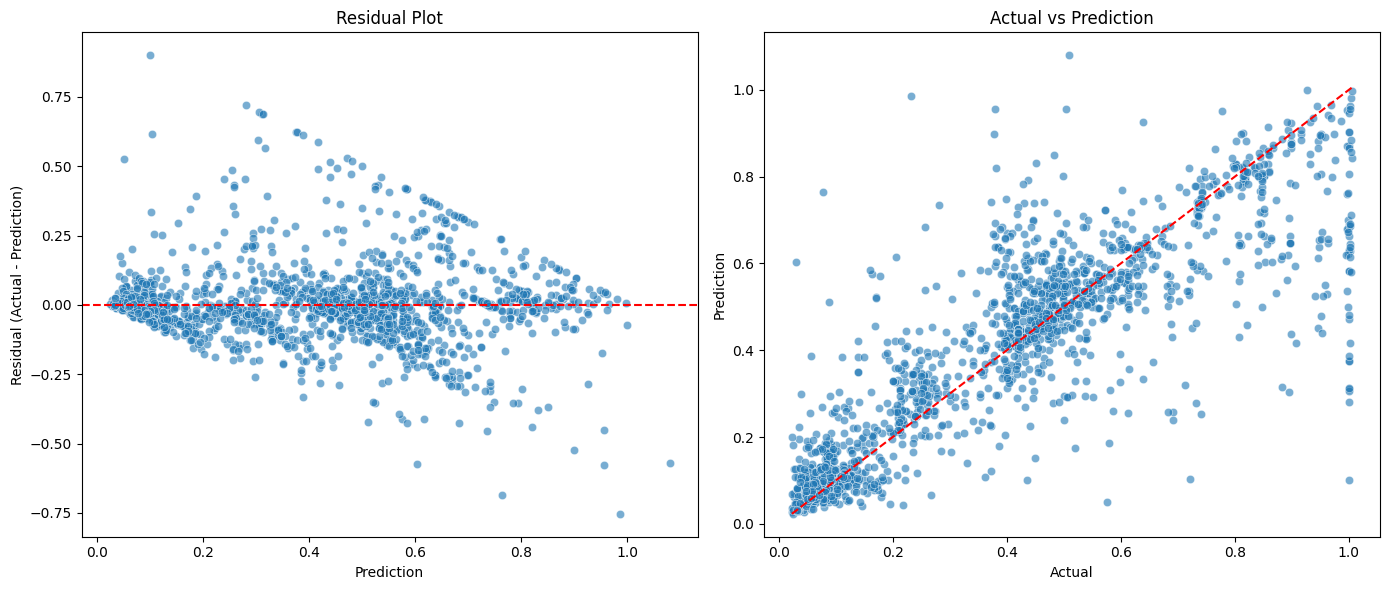

✅ Modelo final guardado como modelo_xgboost.pkl


In [60]:
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold
from sklearn.preprocessing import OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

# ---------- 1. Renombrar columnas ----------
column_map = {
    "Clase": "Class",
    "Eluyente1": "Eluent1",
    "Eluyente2": "Eluent2",
    "pH1": "pH1",
    "pH2": "pH2",
    "USP Code": "USP_Code",
    "Longitud": "Length",
    "Tamaño de Partícula": "Particle_Size",
    "Temperatura": "Temperature",
    "Flujo": "Flow",
    "T0": "T0",
    "Score": "Score",
    "x1": "x1",
    "x2": "x2",
    "x3": "x3",
    "x4": "x4",
    "x5": "x5",
    "x6": "x6",
    "x7": "x7",
    "x8": "x8",
    "x9": "x9",
    "x10": "x10",
    "Intercepto": "Intercept",
    "duration": "Duration"
}
df_smogn.rename(columns=column_map, inplace=True)

# ---------- 2. Función de Preprocesamiento ----------
def preprocess_dataframe(df):
    y = df["Score"].values
    X = df.drop(columns=["Score"]).copy()

    cat_cols = ["Class", "Eluent1", "Eluent2", "USP_Code"]
    encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
    X[cat_cols] = encoder.fit_transform(X[cat_cols])

    return X, y, encoder

# ---------- 3. Preprocesamiento ----------
X_processed, y, encoder = preprocess_dataframe(df_smogn)
y_transformed = y ** 0.25
sample_weights = 1 + 4 * y

# ---------- 4. Validación cruzada ----------
kf = KFold(n_splits=5, shuffle=True, random_state=42)
rmse_scores = []
r2_scores = []
mae_scores = []
all_y_test = []
all_y_pred = []

for fold, (train_index, test_index) in enumerate(kf.split(X_processed)):
    print(f"Fold {fold + 1}")
    X_train, X_test = X_processed.iloc[train_index], X_processed.iloc[test_index]
    y_train, y_test = y_transformed[train_index], y_transformed[test_index]
    weights_train = sample_weights[train_index]

    imputer = SimpleImputer(strategy='mean')
    X_train_imputed = imputer.fit_transform(X_train)
    X_test_imputed = imputer.transform(X_test)

    model = XGBRegressor(
        n_estimators=300,
        learning_rate=0.05,
        random_state=42,
        objective='reg:squarederror',
        verbosity=0
    )
    model.fit(X_train_imputed, y_train, sample_weight=weights_train)

    y_pred = model.predict(X_test_imputed)
    y_pred_original = y_pred ** 2
    y_test_original = y_test ** 2

    all_y_test.extend(y_test_original)
    all_y_pred.extend(y_pred_original)

    rmse = np.sqrt(mean_squared_error(y_test_original, y_pred_original))
    r2 = r2_score(y_test_original, y_pred_original)
    mae = mean_absolute_error(y_test_original, y_pred_original)

    rmse_scores.append(rmse)
    r2_scores.append(r2)
    mae_scores.append(mae)

    print(f"  RMSE: {rmse:.4f} | R²: {r2:.4f} | MAE: {mae:.4f}")

print(f"\nRMSE promedio: {np.mean(rmse_scores):.4f} (±{np.std(rmse_scores):.4f})")
print(f"R² promedio: {np.mean(r2_scores):.4f} (±{np.std(r2_scores):.4f})")
print(f"MAE promedio: {np.mean(mae_scores):.4f} (±{np.std(mae_scores):.4f})")

# ---------- 5. Visualización ----------
all_y_test = np.array(all_y_test)
all_y_pred = np.array(all_y_pred)
residuals = all_y_test - all_y_pred

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sns.scatterplot(x=all_y_pred, y=residuals, alpha=0.6)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Prediction")
plt.ylabel("Residual (Actual - Prediction)")
plt.title("Residual Plot")

plt.subplot(1, 2, 2)
sns.scatterplot(x=all_y_test, y=all_y_pred, alpha=0.6)
plt.plot([min(all_y_test), max(all_y_test)], [min(all_y_test), max(all_y_test)], color='red', linestyle='--')
plt.xlabel("Actual")
plt.ylabel("Prediction")
plt.title("Actual vs Prediction")

plt.tight_layout()
plt.show()

# ---------- 6. Entrenamiento final y guardado ----------
imputer = SimpleImputer(strategy='mean')
X_all_imputed = imputer.fit_transform(X_processed)
y_all_transformed = y ** 0.25
weights_all = 1 + 4 * y

model.fit(X_all_imputed, y_all_transformed, sample_weight=weights_all)

joblib.dump({
    'model': model,
    'imputer': imputer,
    'encoder': encoder,
    'column_order': list(X_processed.columns)
}, "modelo_xgboost.pkl")

print("✅ Modelo final guardado como modelo_xgboost.pkl")


Fold 1
  RMSE: 0.1382 | R²: 0.7368 | MAE: 0.0785
Fold 2
  RMSE: 0.1462 | R²: 0.7195 | MAE: 0.0864
Fold 3
  RMSE: 0.1075 | R²: 0.8401 | MAE: 0.0692
Fold 4
  RMSE: 0.1340 | R²: 0.7583 | MAE: 0.0808
Fold 5
  RMSE: 0.1404 | R²: 0.7351 | MAE: 0.0885

RMSE promedio: 0.1333 (±0.0135)
R² promedio: 0.7580 (±0.0429)
MAE promedio: 0.0807 (±0.0068)


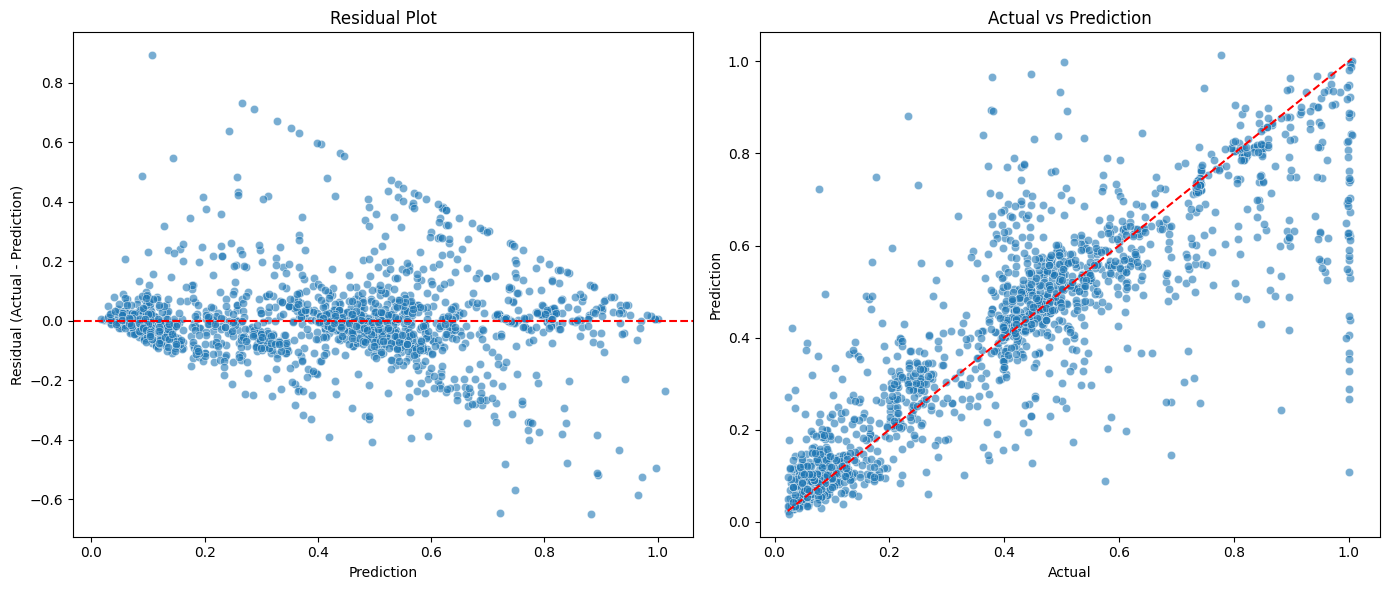

✅ Modelo final guardado como modelo_xgboost.pkl


In [14]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

# ---------- 1. Renombrar columnas ----------
column_map = {
    "Clase": "Class",
    "Eluyente1": "Eluent1",
    "Eluyente2": "Eluent2",
    "pH1": "pH1",
    "pH2": "pH2",
    "USP Code": "USP_Code",
    "Longitud": "Length",
    "Tamaño de Partícula": "Particle_Size",
    "Temperatura": "Temperature",
    "Flujo": "Flow",
    "T0": "T0",
    "Score": "Score",
    "x1": "x1",
    "x2": "x2",
    "x3": "x3",
    "x4": "x4",
    "x5": "x5",
    "x6": "x6",
    "x7": "x7",
    "x8": "x8",
    "x9": "x9",
    "x10": "x10",
    "Intercepto": "Intercept",
    "duration": "Duration"
}
df_smogn.rename(columns=column_map, inplace=True)

# ---------- 2. Función de Preprocesamiento ----------
def preprocess_dataframe(df):
    y = df["Score"].values
    X = df.drop(columns=["Score"]).copy()

    cat_cols = ["Class", "Eluent1", "Eluent2", "USP_Code"]
    encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
    X[cat_cols] = encoder.fit_transform(X[cat_cols])

    return X, y, encoder

# ---------- 3. Preprocesamiento ----------
X_processed, y, encoder = preprocess_dataframe(df_smogn)
y_transformed = y ** 0.25
sample_weights = 1 + 4 * y

# ---------- 4. Estratificación y Validación cruzada ----------
# Crear etiquetas estratificadas a partir de y
n_bins = 10
y_strat = pd.qcut(y, q=n_bins, labels=False, duplicates='drop')  # Etiquetas para estratificación

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
rmse_scores = []
r2_scores = []
mae_scores = []
all_y_test = []
all_y_pred = []

for fold, (train_index, test_index) in enumerate(skf.split(X_processed, y_strat)):
    print(f"Fold {fold + 1}")
    X_train, X_test = X_processed.iloc[train_index], X_processed.iloc[test_index]
    y_train, y_test = y_transformed[train_index], y_transformed[test_index]
    weights_train = sample_weights[train_index]

    imputer = SimpleImputer(strategy='mean')
    X_train_imputed = imputer.fit_transform(X_train)
    X_test_imputed = imputer.transform(X_test)

    model = XGBRegressor(
        n_estimators=300,
        learning_rate=0.05,
        random_state=42,
        objective='reg:squarederror',
        verbosity=0
    )
    model.fit(X_train_imputed, y_train, sample_weight=weights_train)

    y_pred = model.predict(X_test_imputed)
    y_pred_original = y_pred ** 2
    y_test_original = y_test ** 2

    all_y_test.extend(y_test_original)
    all_y_pred.extend(y_pred_original)

    rmse = np.sqrt(mean_squared_error(y_test_original, y_pred_original))
    r2 = r2_score(y_test_original, y_pred_original)
    mae = mean_absolute_error(y_test_original, y_pred_original)

    rmse_scores.append(rmse)
    r2_scores.append(r2)
    mae_scores.append(mae)

    print(f"  RMSE: {rmse:.4f} | R²: {r2:.4f} | MAE: {mae:.4f}")

print(f"\nRMSE promedio: {np.mean(rmse_scores):.4f} (±{np.std(rmse_scores):.4f})")
print(f"R² promedio: {np.mean(r2_scores):.4f} (±{np.std(r2_scores):.4f})")
print(f"MAE promedio: {np.mean(mae_scores):.4f} (±{np.std(mae_scores):.4f})")

# ---------- 5. Visualización ----------
all_y_test = np.array(all_y_test)
all_y_pred = np.array(all_y_pred)
residuals = all_y_test - all_y_pred

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sns.scatterplot(x=all_y_pred, y=residuals, alpha=0.6)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Prediction")
plt.ylabel("Residual (Actual - Prediction)")
plt.title("Residual Plot")

plt.subplot(1, 2, 2)
sns.scatterplot(x=all_y_test, y=all_y_pred, alpha=0.6)
plt.plot([min(all_y_test), max(all_y_test)], [min(all_y_test), max(all_y_test)], color='red', linestyle='--')
plt.xlabel("Actual")
plt.ylabel("Prediction")
plt.title("Actual vs Prediction")

plt.tight_layout()
plt.show()

# ---------- 6. Entrenamiento final y guardado ----------
imputer = SimpleImputer(strategy='mean')
X_all_imputed = imputer.fit_transform(X_processed)
y_all_transformed = y ** 0.25
weights_all = 1 + 4 * y

model.fit(X_all_imputed, y_all_transformed, sample_weight=weights_all)

joblib.dump({
    'model': model,
    'imputer': imputer,
    'encoder': encoder,
    'column_order': list(X_processed.columns)
}, "modelo_xgboost.pkl")

print("✅ Modelo final guardado como modelo_xgboost.pkl")


Fitting 3 folds for each of 6561 candidates, totalling 19683 fits
Mejores hiperparámetros: {'colsample_bytree': 0.7, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 10, 'n_estimators': 100, 'reg_alpha': 0, 'reg_lambda': 1, 'subsample': 0.8}
Fold 1
  RMSE: 0.1573 | R²: 0.6592 | MAE: 0.1118
Fold 2
  RMSE: 0.1632 | R²: 0.6503 | MAE: 0.1188
Fold 3
  RMSE: 0.1367 | R²: 0.7414 | MAE: 0.1041
Fold 4
  RMSE: 0.1524 | R²: 0.6873 | MAE: 0.1164
Fold 5
  RMSE: 0.1539 | R²: 0.6818 | MAE: 0.1120

RMSE promedio: 0.1527 (±0.0088)
R² promedio: 0.6840 (±0.0318)
MAE promedio: 0.1126 (±0.0050)


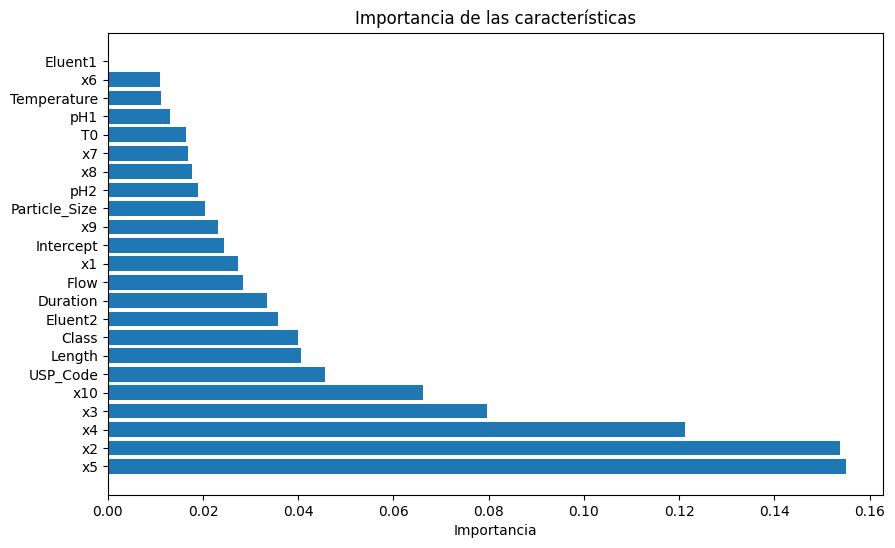

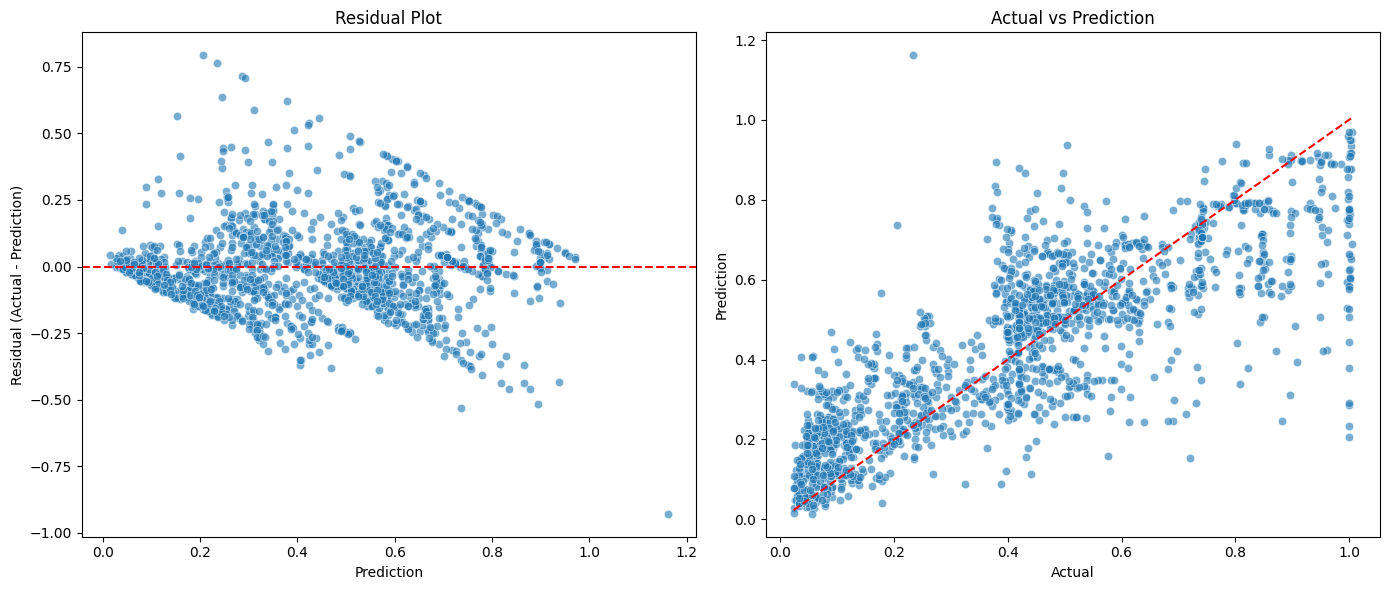

✅ Modelo final guardado como modelo_xgboost_optimizado.pkl


In [15]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.preprocessing import OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

# ---------- 1. Renombrar columnas ----------
column_map = {
    "Clase": "Class",
    "Eluyente1": "Eluent1",
    "Eluyente2": "Eluent2",
    "pH1": "pH1",
    "pH2": "pH2",
    "USP Code": "USP_Code",
    "Longitud": "Length",
    "Tamaño de Partícula": "Particle_Size",
    "Temperatura": "Temperature",
    "Flujo": "Flow",
    "T0": "T0",
    "Score": "Score",
    "x1": "x1",
    "x2": "x2",
    "x3": "x3",
    "x4": "x4",
    "x5": "x5",
    "x6": "x6",
    "x7": "x7",
    "x8": "x8",
    "x9": "x9",
    "x10": "x10",
    "Intercepto": "Intercept",
    "duration": "Duration"
}
df_smogn.rename(columns=column_map, inplace=True)

# ---------- 2. Función de Preprocesamiento ----------
def preprocess_dataframe(df):
    y = df["Score"].values
    X = df.drop(columns=["Score"]).copy()

    cat_cols = ["Class", "Eluent1", "Eluent2", "USP_Code"]
    encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
    X[cat_cols] = encoder.fit_transform(X[cat_cols])

    return X, y, encoder

# ---------- 3. Preprocesamiento ----------
X_processed, y, encoder = preprocess_dataframe(df_smogn)
y_transformed = y ** 0.25
sample_weights = 1 + 4 * y

# ---------- 4. Estratificación y Validación cruzada ----------
# Crear etiquetas estratificadas a partir de y
n_bins = 10
y_strat = pd.qcut(y, q=n_bins, labels=False, duplicates='drop')  # Etiquetas para estratificación

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
rmse_scores = []
r2_scores = []
mae_scores = []
all_y_test = []
all_y_pred = []

# Definir los hiperparámetros a optimizar
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 6, 10],
    'min_child_weight': [1, 5, 10],
    'subsample': [0.7, 0.8, 1.0],
    'colsample_bytree': [0.7, 0.8, 1.0],
    'reg_alpha': [0, 0.1, 1],
    'reg_lambda': [0, 0.1, 1]
}

# Crear el objeto XGBRegressor para GridSearchCV
model = XGBRegressor(
    objective='reg:squarederror',
    verbosity=0,
    random_state=42
)

# Realizar la búsqueda de hiperparámetros
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, scoring='neg_mean_squared_error', n_jobs=-1, verbose=1)
grid_search.fit(X_processed, y_transformed)

# Mostrar el mejor conjunto de hiperparámetros
print(f"Mejores hiperparámetros: {grid_search.best_params_}")

# Usar el mejor modelo del grid search
best_model = grid_search.best_estimator_

# Realizar validación cruzada con el mejor modelo
for fold, (train_index, test_index) in enumerate(skf.split(X_processed, y_strat)):
    print(f"Fold {fold + 1}")
    X_train, X_test = X_processed.iloc[train_index], X_processed.iloc[test_index]
    y_train, y_test = y_transformed[train_index], y_transformed[test_index]
    weights_train = sample_weights[train_index]

    imputer = SimpleImputer(strategy='mean')
    X_train_imputed = imputer.fit_transform(X_train)
    X_test_imputed = imputer.transform(X_test)

    best_model.fit(X_train_imputed, y_train, sample_weight=weights_train)

    y_pred = best_model.predict(X_test_imputed)
    y_pred_original = y_pred ** 2
    y_test_original = y_test ** 2

    all_y_test.extend(y_test_original)
    all_y_pred.extend(y_pred_original)

    rmse = np.sqrt(mean_squared_error(y_test_original, y_pred_original))
    r2 = r2_score(y_test_original, y_pred_original)
    mae = mean_absolute_error(y_test_original, y_pred_original)

    rmse_scores.append(rmse)
    r2_scores.append(r2)
    mae_scores.append(mae)

    print(f"  RMSE: {rmse:.4f} | R²: {r2:.4f} | MAE: {mae:.4f}")

print(f"\nRMSE promedio: {np.mean(rmse_scores):.4f} (±{np.std(rmse_scores):.4f})")
print(f"R² promedio: {np.mean(r2_scores):.4f} (±{np.std(r2_scores):.4f})")
print(f"MAE promedio: {np.mean(mae_scores):.4f} (±{np.std(mae_scores):.4f})")

# ---------- 5. Visualización de la Importancia de Características ----------
importances = best_model.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10, 6))
plt.title("Importancia de las características")
plt.barh(range(X_processed.shape[1]), importances[indices], align="center")
plt.yticks(range(X_processed.shape[1]), X_processed.columns[indices])
plt.xlabel("Importancia")
plt.show()

# ---------- 6. Visualización de Residuales y Predicciones ----------
all_y_test = np.array(all_y_test)
all_y_pred = np.array(all_y_pred)
residuals = all_y_test - all_y_pred

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sns.scatterplot(x=all_y_pred, y=residuals, alpha=0.6)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Prediction")
plt.ylabel("Residual (Actual - Prediction)")
plt.title("Residual Plot")

plt.subplot(1, 2, 2)
sns.scatterplot(x=all_y_test, y=all_y_pred, alpha=0.6)
plt.plot([min(all_y_test), max(all_y_test)], [min(all_y_test), max(all_y_test)], color='red', linestyle='--')
plt.xlabel("Actual")
plt.ylabel("Prediction")
plt.title("Actual vs Prediction")

plt.tight_layout()
plt.show()

# ---------- 7. Entrenamiento final y guardado ----------
imputer = SimpleImputer(strategy='mean')
X_all_imputed = imputer.fit_transform(X_processed)
y_all_transformed = y ** 0.25
weights_all = 1 + 4 * y

best_model.fit(X_all_imputed, y_all_transformed, sample_weight=weights_all)

joblib.dump({
    'model': best_model,
    'imputer': imputer,
    'encoder': encoder,
    'column_order': list(X_processed.columns)
}, "modelo_xgboost_optimizado.pkl")

print("✅ Modelo final guardado como modelo_xgboost_optimizado.pkl")


In [17]:
import pandas as pd
df_smogn = pd.read_csv("df_smogn.csv")

In [ ]:
# Quitamos el CHEMOTID
df_smogn["class"] = df_smogn["class"].str.extract(r'^(.*?)\s+\(CHEMONTID:')


In [32]:
df_smogn["column_usp_code"] = df_smogn["column_usp_code"].str.split("_").str[-1]

In [35]:
df_smogn["eluent_1"] = df_smogn["eluent_1"].str.split(".").str[-1].str.split(" ").str[0]


In [37]:
df_smogn["eluent_2"] = df_smogn["eluent_2"].str.split(".").str[-1].str.split(" ").str[0]

In [38]:
#set(df_smogn["class"])
#set(df_smogn["column_usp_code"])
#set(df_smogn["eluent_1"])
set(df_smogn["eluent_2"])

{'acn', 'h2o', 'meoh'}

Fitting 3 folds for each of 48 candidates, totalling 144 fits
Mejores hiperparámetros: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.8}
Fold 1
  RMSE: 0.1483 | R²: 0.6970 | MAE: 0.1039
Fold 2
  RMSE: 0.1634 | R²: 0.6492 | MAE: 0.1169
Fold 3
  RMSE: 0.1332 | R²: 0.7545 | MAE: 0.1000
Fold 4
  RMSE: 0.1510 | R²: 0.6926 | MAE: 0.1150
Fold 5
  RMSE: 0.1530 | R²: 0.6852 | MAE: 0.1115

RMSE promedio: 0.1498 (±0.0098)
R² promedio: 0.6957 (±0.0339)
MAE promedio: 0.1095 (±0.0065)


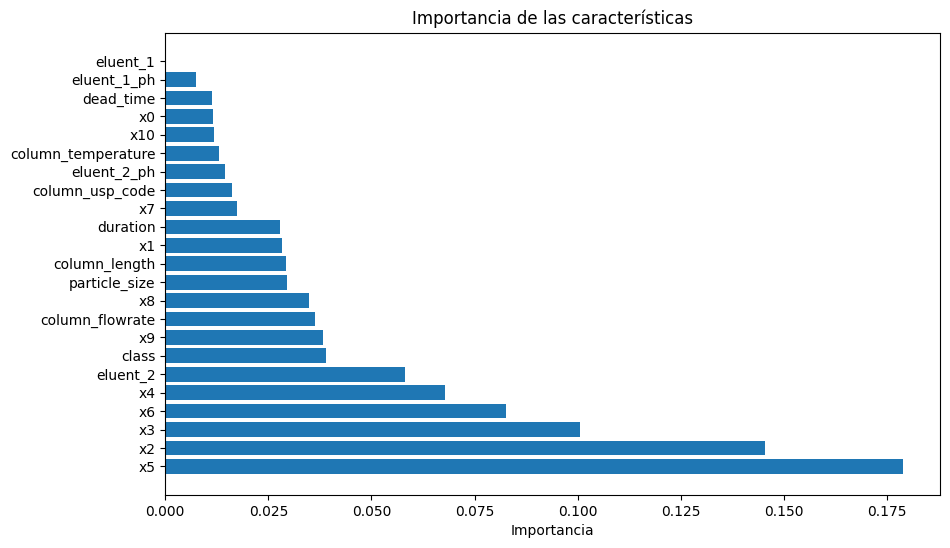

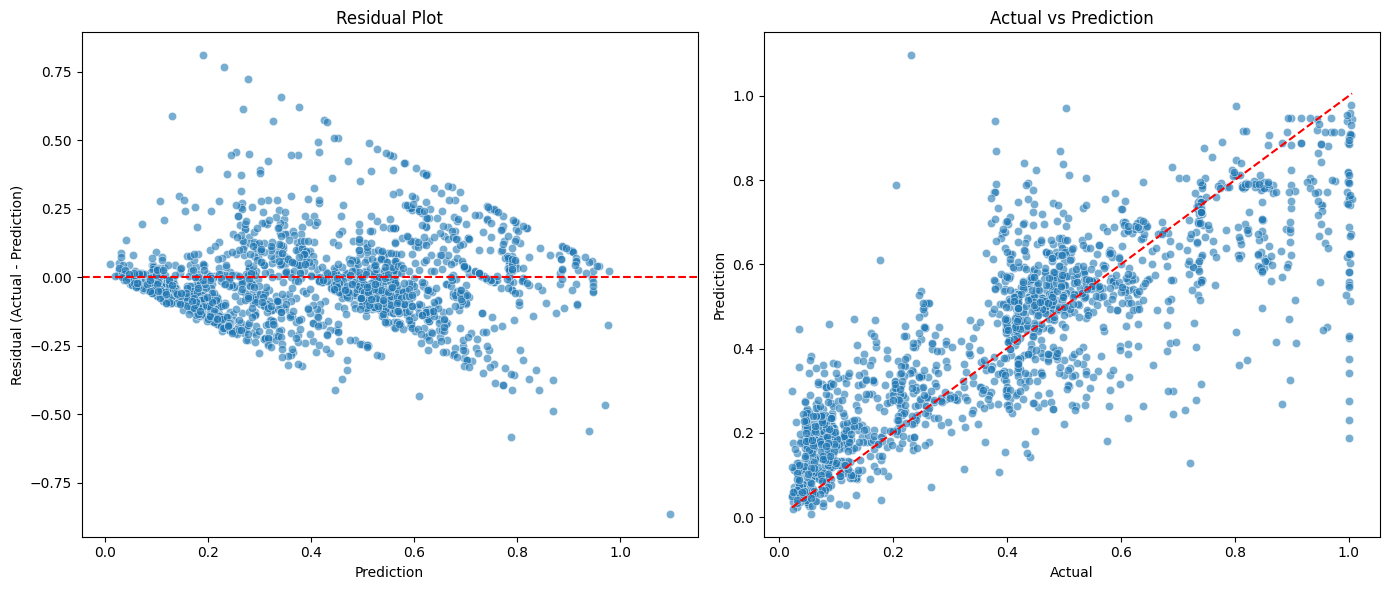

✅ Modelo final guardado como modelo_xgboost_ajustado.pkl


In [40]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.preprocessing import OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

# ---------- 1. Renombrar columnas ----------
'''
column_map = {
    "Clase": "Class",
    "Eluyente1": "Eluent1",
    "Eluyente2": "Eluent2",
    "pH1": "pH1",
    "pH2": "pH2",
    "USP Code": "USP_Code",
    "Longitud": "Length",
    "Tamaño de Partícula": "Particle_Size",
    "Temperatura": "Temperature",
    "Flujo": "Flow",
    "T0": "T0",
    "Score": "Score",
    "x1": "x1",
    "x2": "x2",
    "x3": "x3",
    "x4": "x4",
    "x5": "x5",
    "x6": "x6",
    "x7": "x7",
    "x8": "x8",
    "x9": "x9",
    "x10": "x10",
    "Intercepto": "Intercept",
    "duration": "Duration"
}'''
column_map = {
    "Clase": "class",
    "Eluyente1": "eluent_1",
    "Eluyente2": "eluent_2",
    "pH1": "eluent_1_ph",
    "pH2": "eluent_2_ph",
    "USP Code": "column_usp_code",
    "Longitud": "column_length",
    "Tamaño de Partícula": "particle_size",
    "Temperatura": "column_temperature",
    "Flujo": "column_flowrate",
    "T0": "dead_time",
    "Score": "score",
    "Intercepto": "x0",
    "x1": "x1",
    "x2": "x2",
    "x3": "x3",
    "x4": "x4",
    "x5": "x5",
    "x6": "x6",
    "x7": "x7",
    "x8": "x8",
    "x9": "x9",
    "x10": "x10",
    "duration": "duration"
}

df_smogn.rename(columns=column_map, inplace=True)

# ---------- 2. Función de Preprocesamiento ----------
def preprocess_dataframe(df):
    y = df["score"].values
    X = df.drop(columns=["score"]).copy()

    #cat_cols = ["Class", "Eluent1", "Eluent2", "USP_Code"]
    cat_cols = ["class", "eluent_1", "eluent_2", "column_usp_code"]
    encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
    X[cat_cols] = encoder.fit_transform(X[cat_cols])

    return X, y, encoder

# ---------- 3. Preprocesamiento ----------
X_processed, y, encoder = preprocess_dataframe(df_smogn)
y_transformed = y ** 0.25
sample_weights = 1 + 4 * y

# ---------- 4. Estratificación y Validación cruzada ----------
# Crear etiquetas estratificadas a partir de y
n_bins = 10
y_strat = pd.qcut(y, q=n_bins, labels=False, duplicates='drop')  # Etiquetas para estratificación

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
rmse_scores = []
r2_scores = []
mae_scores = []
all_y_test = []
all_y_pred = []

# Ajustar el rango de hiperparámetros para evitar una búsqueda de cuadrícula amplia
param_grid = {
    'n_estimators': [100, 150, 200],  # Reducir la cantidad de estimadores
    'learning_rate': [0.05, 0.1],  # Rango más pequeño para la tasa de aprendizaje
    'max_depth': [3, 5],  # Reducir la profundidad máxima
    'subsample': [0.8, 1.0],  # Rango de subsample
    'colsample_bytree': [0.8, 1.0],  # Similar a subsample
}

# Crear el objeto XGBRegressor para GridSearchCV
model = XGBRegressor(
    objective='reg:squarederror',
    verbosity=0,
    random_state=42
)

# Realizar la búsqueda de hiperparámetros
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, scoring='neg_mean_squared_error', n_jobs=-1, verbose=1)
grid_search.fit(X_processed, y_transformed)

# Mostrar el mejor conjunto de hiperparámetros
print(f"Mejores hiperparámetros: {grid_search.best_params_}")

# Usar el mejor modelo del grid search
best_model = grid_search.best_estimator_

# Realizar validación cruzada con el mejor modelo
for fold, (train_index, test_index) in enumerate(skf.split(X_processed, y_strat)):
    print(f"Fold {fold + 1}")
    X_train, X_test = X_processed.iloc[train_index], X_processed.iloc[test_index]
    y_train, y_test = y_transformed[train_index], y_transformed[test_index]
    weights_train = sample_weights[train_index]

    imputer = SimpleImputer(strategy='mean')
    X_train_imputed = imputer.fit_transform(X_train)
    X_test_imputed = imputer.transform(X_test)

    best_model.fit(X_train_imputed, y_train, sample_weight=weights_train)

    y_pred = best_model.predict(X_test_imputed)
    y_pred_original = y_pred ** 2
    y_test_original = y_test ** 2

    all_y_test.extend(y_test_original)
    all_y_pred.extend(y_pred_original)

    rmse = np.sqrt(mean_squared_error(y_test_original, y_pred_original))
    r2 = r2_score(y_test_original, y_pred_original)
    mae = mean_absolute_error(y_test_original, y_pred_original)

    rmse_scores.append(rmse)
    r2_scores.append(r2)
    mae_scores.append(mae)

    print(f"  RMSE: {rmse:.4f} | R²: {r2:.4f} | MAE: {mae:.4f}")

print(f"\nRMSE promedio: {np.mean(rmse_scores):.4f} (±{np.std(rmse_scores):.4f})")
print(f"R² promedio: {np.mean(r2_scores):.4f} (±{np.std(r2_scores):.4f})")
print(f"MAE promedio: {np.mean(mae_scores):.4f} (±{np.std(mae_scores):.4f})")

# ---------- 5. Visualización de la Importancia de Características ----------
importances = best_model.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10, 6))
plt.title("Importancia de las características")
plt.barh(range(X_processed.shape[1]), importances[indices], align="center")
plt.yticks(range(X_processed.shape[1]), X_processed.columns[indices])
plt.xlabel("Importancia")
plt.show()

# ---------- 6. Visualización de Residuales y Predicciones ----------
all_y_test = np.array(all_y_test)
all_y_pred = np.array(all_y_pred)
residuals = all_y_test - all_y_pred

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sns.scatterplot(x=all_y_pred, y=residuals, alpha=0.6)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Prediction")
plt.ylabel("Residual (Actual - Prediction)")
plt.title("Residual Plot")

plt.subplot(1, 2, 2)
sns.scatterplot(x=all_y_test, y=all_y_pred, alpha=0.6)
plt.plot([min(all_y_test), max(all_y_test)], [min(all_y_test), max(all_y_test)], color='red', linestyle='--')
plt.xlabel("Actual")
plt.ylabel("Prediction")
plt.title("Actual vs Prediction")

plt.tight_layout()
plt.show()

# ---------- 7. Entrenamiento final y guardado ----------
imputer = SimpleImputer(strategy='mean')
X_all_imputed = imputer.fit_transform(X_processed)
y_all_transformed = y ** 0.25
weights_all = 1 + 4 * y

best_model.fit(X_all_imputed, y_all_transformed, sample_weight=weights_all)

joblib.dump({
    'model': best_model,
    'imputer': imputer,
    'encoder': encoder,
    'column_order': list(X_processed.columns)
}, "modelo_xgboost.pkl")

print("✅ Modelo final guardado como modelo_xgboost_ajustado.pkl")


Fold 1
  RMSE: 0.1331 | R²: 0.7689 | MAE: 0.0752
Fold 2
  RMSE: 0.1455 | R²: 0.7042 | MAE: 0.0841
Fold 3
  RMSE: 0.1440 | R²: 0.7259 | MAE: 0.0838
Fold 4
  RMSE: 0.1358 | R²: 0.7427 | MAE: 0.0785
Fold 5
  RMSE: 0.1299 | R²: 0.7693 | MAE: 0.0748

RMSE promedio: 0.1377 (±0.0061)
R² promedio: 0.7422 (±0.0251)
MAE promedio: 0.0793 (±0.0040)


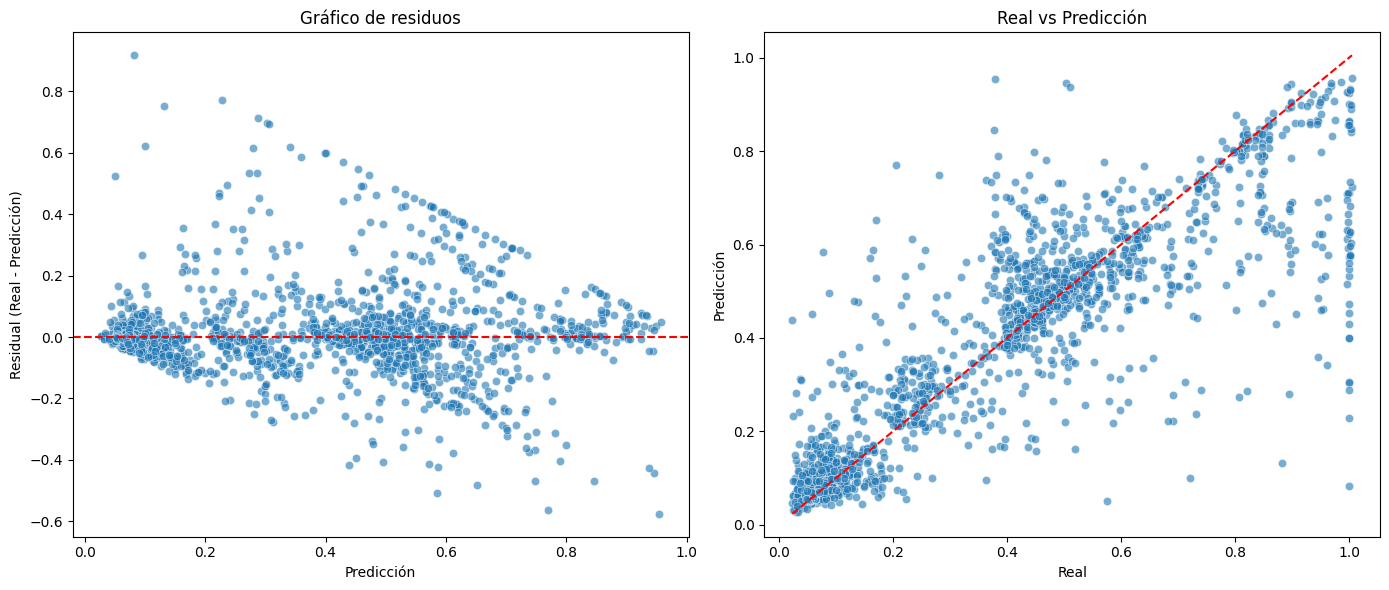

In [42]:
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold
from sklearn.preprocessing import OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns

column_map = {
    "Clase": "class",
    "Eluyente1": "eluent_1",
    "Eluyente2": "eluent_2",
    "pH1": "eluent_1_ph",
    "pH2": "eluent_2_ph",
    "USP Code": "column_usp_code",
    "Longitud": "column_length",
    "Tamaño de Partícula": "particle_size",
    "Temperatura": "column_temperature",
    "Flujo": "column_flowrate",
    "T0": "dead_time",
    "Score": "score",
    "Intercepto": "x0",
    "x1": "x1",
    "x2": "x2",
    "x3": "x3",
    "x4": "x4",
    "x5": "x5",
    "x6": "x6",
    "x7": "x7",
    "x8": "x8",
    "x9": "x9",
    "x10": "x10",
    "duration": "duration"
}

df_smogn.rename(columns=column_map, inplace=True)
# ---------- 1. Función de Preprocesamiento ----------
def preprocess_dataframe(df):
    y = df["score"].values
    X = df.drop(columns=["score"]).copy()

    # Codificación de variables categóricas
    #cat_cols = ["Clase", "Eluyente1", "Eluyente2", "USP Code"]
    cat_cols = ["class", "eluent_1", "eluent_2", "column_usp_code"]
    encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
    X[cat_cols] = encoder.fit_transform(X[cat_cols])

    return X, y, encoder

# ---------- 2. Preprocesamiento de datos ----------
X_processed, y, encoder = preprocess_dataframe(df_smogn)

# Transformación de la variable objetivo
y_transformed = y**0.25

# Pesos de ejemplo para dar más importancia a valores altos de Score
sample_weights = 1 + 4 * y

# ---------- 3. Validación cruzada ----------
kf = KFold(n_splits=5, shuffle=True, random_state=42)
rmse_scores = []
r2_scores = []
mae_scores = []

# Para visualización
all_y_test = []
all_y_pred = []

for fold, (train_index, test_index) in enumerate(kf.split(X_processed)):
    print(f"Fold {fold + 1}")

    X_train, X_test = X_processed.iloc[train_index], X_processed.iloc[test_index]
    y_train, y_test = y_transformed[train_index], y_transformed[test_index]
    weights_train = sample_weights[train_index]

    # Imputación
    imputer = SimpleImputer(strategy='mean')
    X_train_imputed = imputer.fit_transform(X_train)
    X_test_imputed = imputer.transform(X_test)

    # Entrenamiento del modelo Random Forest
    model = RandomForestRegressor(
        n_estimators=300,
        max_depth=None,
        random_state=42,
        n_jobs=-1
    )
    model.fit(X_train_imputed, y_train, sample_weight=weights_train)

    # Predicción
    y_pred = model.predict(X_test_imputed)

    # Destransformar
    y_pred_original = y_pred ** 2
    y_test_original = y_test ** 2

    # Guardar para visualización
    all_y_test.extend(y_test_original)
    all_y_pred.extend(y_pred_original)

    # Métricas
    rmse = np.sqrt(mean_squared_error(y_test_original, y_pred_original))
    r2 = r2_score(y_test_original, y_pred_original)
    mae = mean_absolute_error(y_test_original, y_pred_original)

    rmse_scores.append(rmse)
    r2_scores.append(r2)
    mae_scores.append(mae)

    print(f"  RMSE: {rmse:.4f} | R²: {r2:.4f} | MAE: {mae:.4f}")

# ---------- 4. Resultados Finales ----------
print(f"\nRMSE promedio: {np.mean(rmse_scores):.4f} (±{np.std(rmse_scores):.4f})")
print(f"R² promedio: {np.mean(r2_scores):.4f} (±{np.std(r2_scores):.4f})")
print(f"MAE promedio: {np.mean(mae_scores):.4f} (±{np.std(mae_scores):.4f})")

# ---------- 5. Visualización de Validación ----------
all_y_test = np.array(all_y_test)
all_y_pred = np.array(all_y_pred)
residuals = all_y_test - all_y_pred

plt.figure(figsize=(14, 6))

# Gráfico de residuos
plt.subplot(1, 2, 1)
sns.scatterplot(x=all_y_pred, y=residuals, alpha=0.6)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicción")
plt.ylabel("Residual (Real - Predicción)")
plt.title("Gráfico de residuos")

# Predicción vs Real
plt.subplot(1, 2, 2)
sns.scatterplot(x=all_y_test, y=all_y_pred, alpha=0.6)
plt.plot([min(all_y_test), max(all_y_test)], [min(all_y_test), max(all_y_test)], color='red', linestyle='--')
plt.xlabel("Real")
plt.ylabel("Predicción")
plt.title("Real vs Predicción")

plt.tight_layout()
plt.show()


Fold 1
  RMSE: 0.1331 | R²: 0.7689 | MAE: 0.0752
Fold 2
  RMSE: 0.1455 | R²: 0.7042 | MAE: 0.0841
Fold 3
  RMSE: 0.1440 | R²: 0.7259 | MAE: 0.0838
Fold 4
  RMSE: 0.1358 | R²: 0.7427 | MAE: 0.0785
Fold 5
  RMSE: 0.1299 | R²: 0.7693 | MAE: 0.0748

RMSE promedio: 0.1377 ± 0.0061
R² promedio: 0.7422 ± 0.0251
MAE promedio: 0.0793 ± 0.0040


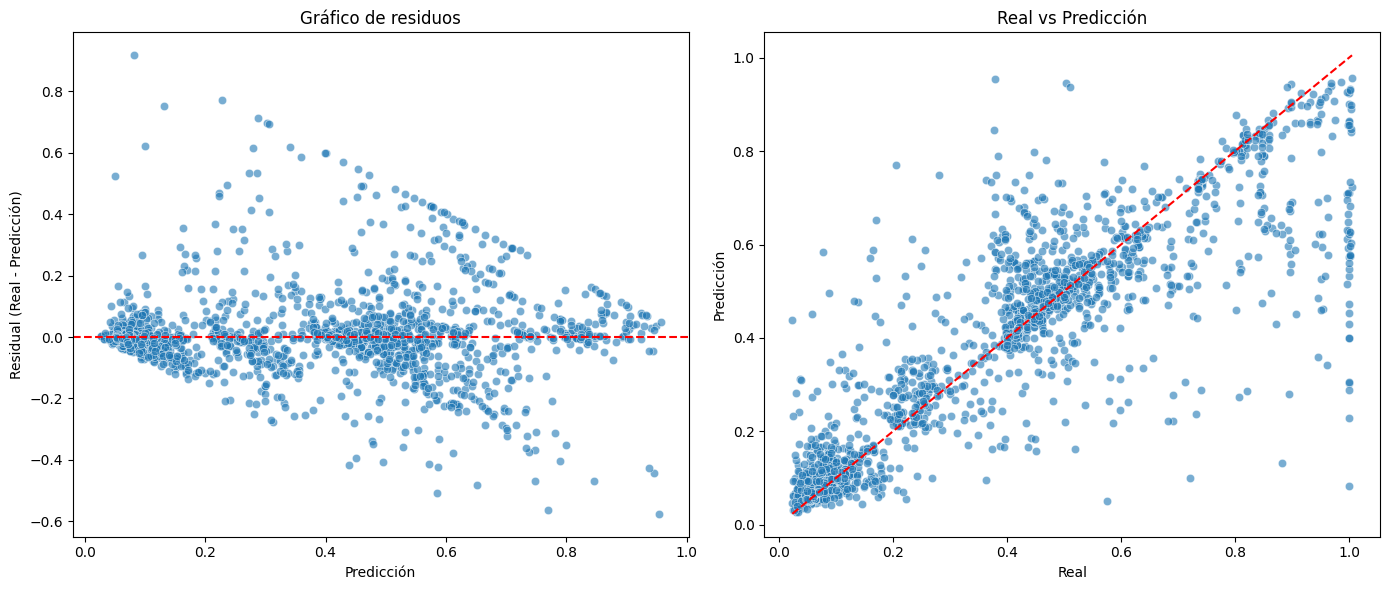

✅ Modelo final guardado como modelo_random_forest_completo.pkl


In [44]:
import pandas as pd
import numpy as np
import joblib
from sklearn.model_selection import KFold
from sklearn.preprocessing import OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns

# ---------- 0. Cargar y renombrar df_smogn ----------
# Asume que df_smogn ya está cargado en tu entorno
column_map = {
    "Clase": "class",
    "Eluyente1": "eluent_1",
    "Eluyente2": "eluent_2",
    "pH1": "eluent_1_ph",
    "pH2": "eluent_2_ph",
    "USP Code": "column_usp_code",
    "Longitud": "column_length",
    "Tamaño de Partícula": "particle_size",
    "Temperatura": "column_temperature",
    "Flujo": "column_flowrate",
    "T0": "dead_time",
    "Score": "score",
    "Intercepto": "x0",
    "x1": "x1",
    "x2": "x2",
    "x3": "x3",
    "x4": "x4",
    "x5": "x5",
    "x6": "x6",
    "x7": "x7",
    "x8": "x8",
    "x9": "x9",
    "x10": "x10",
    "duration": "duration"
}
df_smogn.rename(columns=column_map, inplace=True)

# ---------- 1. Función de Preprocesamiento ----------
def preprocess_dataframe(df):
    y = df["score"].values
    X = df.drop(columns=["score"]).copy()

    # Codificar categóricas
    cat_cols = ["class", "eluent_1", "eluent_2", "column_usp_code"]
    encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
    X[cat_cols] = encoder.fit_transform(X[cat_cols])

    return X, y, encoder

# ---------- 2. Preprocesamiento de datos ----------
X_processed, y, encoder = preprocess_dataframe(df_smogn)

# Transformación de la variable objetivo
y_transformed = y ** 0.25

# Pesos para valores altos de score
sample_weights = 1 + 4 * y

# ---------- 3. Validación cruzada ----------
kf = KFold(n_splits=5, shuffle=True, random_state=42)
rmse_scores, r2_scores, mae_scores = [], [], []
all_y_test, all_y_pred = [], []

for fold, (train_idx, test_idx) in enumerate(kf.split(X_processed), 1):
    print(f"Fold {fold}")

    X_train, X_test = X_processed.iloc[train_idx], X_processed.iloc[test_idx]
    y_train, y_test = y_transformed[train_idx], y_transformed[test_idx]
    w_train = sample_weights[train_idx]

    # Imputación
    imputer = SimpleImputer(strategy='mean')
    X_tr_imp = imputer.fit_transform(X_train)
    X_te_imp = imputer.transform(X_test)

    # Modelo
    model = RandomForestRegressor(
        n_estimators=300,
        max_depth=None,
        random_state=42,
        n_jobs=-1
    )
    model.fit(X_tr_imp, y_train, sample_weight=w_train)

    # Predicción
    y_pred = model.predict(X_te_imp)

    # Destransformar
    y_pred_orig = y_pred ** 2
    y_test_orig = y_test ** 2

    # Guardar para visualización
    all_y_test.extend(y_test_orig)
    all_y_pred.extend(y_pred_orig)

    # Métricas
    rmse = np.sqrt(mean_squared_error(y_test_orig, y_pred_orig))
    r2   = r2_score(y_test_orig, y_pred_orig)
    mae  = mean_absolute_error(y_test_orig, y_pred_orig)
    rmse_scores.append(rmse)
    r2_scores.append(r2)
    mae_scores.append(mae)

    print(f"  RMSE: {rmse:.4f} | R²: {r2:.4f} | MAE: {mae:.4f}")

# ---------- 4. Resultados Finales ----------
print(f"\nRMSE promedio: {np.mean(rmse_scores):.4f} ± {np.std(rmse_scores):.4f}")
print(f"R² promedio: {np.mean(r2_scores):.4f} ± {np.std(r2_scores):.4f}")
print(f"MAE promedio: {np.mean(mae_scores):.4f} ± {np.std(mae_scores):.4f}")

# ---------- 5. Visualización de Validación ----------
all_y_test = np.array(all_y_test)
all_y_pred = np.array(all_y_pred)
residuals = all_y_test - all_y_pred

plt.figure(figsize=(14, 6))

# Residuales
plt.subplot(1, 2, 1)
sns.scatterplot(x=all_y_pred, y=residuals, alpha=0.6)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicción")
plt.ylabel("Residual (Real - Predicción)")
plt.title("Gráfico de residuos")

# Real vs Predicción
plt.subplot(1, 2, 2)
sns.scatterplot(x=all_y_test, y=all_y_pred, alpha=0.6)
plt.plot([all_y_test.min(), all_y_test.max()],
         [all_y_test.min(), all_y_test.max()],
         color='red', linestyle='--')
plt.xlabel("Real")
plt.ylabel("Predicción")
plt.title("Real vs Predicción")

plt.tight_layout()
plt.show()

# ---------- 6. Entrenamiento final y guardado ----------
# Definir el modelo final (mismos hiperparámetros)
best_model = RandomForestRegressor(
    n_estimators=300,
    max_depth=None,
    random_state=42,
    n_jobs=-1
)

# Imputar todo X_processed
imputer_final = SimpleImputer(strategy='mean')
X_all_imp = imputer_final.fit_transform(X_processed)

# Transformar y y calcular pesos
y_all_trans = y ** 0.25
weights_all = 1 + 4 * y

# Entrenar
best_model.fit(X_all_imp, y_all_trans, sample_weight=weights_all)

# Guardar artefactos
joblib.dump({
    'model': best_model,
    'imputer': imputer_final,
    'encoder': encoder,
    'column_order': list(X_processed.columns)
}, "modelo_random_forest_completo.pkl")

print("✅ Modelo final guardado como modelo_random_forest_completo.pkl")
